In [18]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

###!@0 END INIT ENVIRONMENT

#######################################
###!@1 START OF PYSPARK INIT
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


time: 12.1 s (started: 2021-12-10 18:52:03 +00:00)


In [19]:
#######################################
###!@2 START OF DEFINING INPUT FILES
#pfile = "/content/drive/MyDrive/US_youtube_trending_data.csv"
pfile = "/content/drive/MyDrive/youtube_trending_video_dataset/US_youtube_trending_data.csv"
jfile = "/content/drive/MyDrive/youtube_trending_video_dataset/US_category_id.json"

#jfile = "/content/drive/MyDrive/US_category_id.json"
###!@2 END OF DEFINING INPUT FILES

#######################################
###!@3 START OF LOADING DATA
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import date
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

!pip install ipython-autotime
%load_ext autotime
##########################


# load USA YT data from CSV
print("USA VIDEO DATA SET")
usadf = spark.read.option("header",True).option("inferSchema",True).option("multiline","true").csv(pfile).where(col("video_id").isNotNull())
usadf.show(5)

# Load US Json
print("USA VIDEO DATA SET CATEGORY and ID")
ytvusjdf = spark.read.option("multiline","true").json(jfile).select(explode("items").alias("itemsExplode")).select("itemsExplode.*").withColumn("Category", col("snippet").title).drop("etag", "kind", "snippet")
ytvusjdf.show(10)


#cfile = "/content/drive/MyDrive/YouTubeProjectSem1/US_youtube_trending_data.csv"
#jfile = "/content/drive/MyDrive/YouTubeProjectSem1/US_category_id.json"

#c1file = "/content/drive/MyDrive/YouTubeProjectSem1/GB_youtube_trending_data.csv"
#j1file = "/content/drive/MyDrive/YouTubeProjectSem1/GB_category_id.json"

#c2file = "/content/drive/MyDrive/YouTubeProjectSem1/IN_youtube_trending_data.csv"
#j2file = "/content/drive/MyDrive/YouTubeProjectSem1/IN_category_id.json"

cfile = "/content/drive/MyDrive/youtube_trending_video_dataset/US_youtube_trending_data.csv"
jfile = "/content/drive/MyDrive/youtube_trending_video_dataset/US_category_id.json"

c1file = "/content/drive/MyDrive/youtube_trending_video_dataset/GB_youtube_trending_data.csv"
j1file = "/content/drive/MyDrive/youtube_trending_video_dataset/GB_category_id.json"

c2file = "/content/drive/MyDrive/youtube_trending_video_dataset/IN_youtube_trending_data.csv"
j2file = "/content/drive/MyDrive/youtube_trending_video_dataset/IN_category_id.json"
#######################################
###!@3 START OF LOADING DATA
##########################

# load US data from CSV
uscdf = usadf
#uscdf = spark.read.option("header",True).option("inferSchema",True).option("multiline","true").csv(cfile).where(col("video_id").isNotNull())
gbcdf = spark.read.option("header",True).option("inferSchema",True).option("multiline","true").csv(c1file).where(col("video_id").isNotNull())
incdf = spark.read.option("header",True).option("inferSchema",True).option("multiline","true").csv(c2file).where(col("video_id").isNotNull())
print("USA VIDEO DATA SET")
uscdf.show(5)
print("Great Britain VIDEO DATA SET")
gbcdf.show(5)
print("India VIDEO DATA SET")
incdf.show(5)

# # Load US Json
usjdf = ytvusjdf
#usjdf = spark.read.option("multiline","true").json(jfile).select(explode("items").alias("itemsExplode")).select("itemsExplode.*").withColumn("Category", col("snippet").title).drop("etag", "kind", "snippet")
gbjdf = spark.read.option("multiline","true").json(j1file).select(explode("items").alias("itemsExplode")).select("itemsExplode.*").withColumn("Category", col("snippet").title).drop("etag", "kind", "snippet")
injdf = spark.read.option("multiline","true").json(j2file).select(explode("items").alias("itemsExplode")).select("itemsExplode.*").withColumn("Category", col("snippet").title).drop("etag", "kind", "snippet")
print("USA VIDEO DATA SET CATEGORY and ID")
usjdf.show(5)
print("Great Britain VIDEO DATA SET CATEGORY and ID")
gbjdf.show(5)
print("India VIDEO DATA SET CATEGORY and ID")
injdf.show(5)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
USA VIDEO DATA SET
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|   video_id|               title|        publishedAt|           channelId| channelTitle|categoryId|      trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|         description|
+-----------+--------------------+-------------------+--------------------+-------------+----------+-------------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|3C66w5Z0ixs|I ASKED HER TO BE...|2020-08-11 19:20:14|UCvtRTOMP2TqYqu51...|     Brawadis|        22|2020-08-12 00:00:

In [20]:
# 1. EDA of trending video metrics:
# a) : How many number of views/comments/likes videos had when they first became trending? Visualization through histograms and plots.
# Note: If ratings_disabled is True than no Likes and Dislikes values

cleandf_1a = usadf.withColumn("view_count", col("view_count").cast("double")).withColumn("likes", col("likes").cast("double")).\
            withColumn("trending_date", col("trending_date").cast("date")).withColumn("comment_count", col("comment_count").cast("double"))\
            .withColumn("dislikes", col("dislikes").cast("double"))\
            .drop("thumbnail_link", "description", "tags") #,"comments_disabled","ratings_disabled")

firsttrendingdf_1a = cleandf_1a.select("video_id", expr("date(trending_date)")).\
             groupBy("video_id").agg(F.min("trending_date")).withColumnRenamed("min(trending_date)","tdate")\
             .withColumnRenamed("video_id","vid")

finaldf_1a = cleandf_1a.join(firsttrendingdf_1a, ((cleandf_1a.trending_date == firsttrendingdf_1a.tdate) & \
                            (cleandf_1a.video_id == firsttrendingdf_1a.vid))).drop("vid", "tdate")
finaldf_1a.show(10)
finaldf_1a.printSchema()

+-----------+--------------------+-------------------+--------------------+--------------------+----------+-------------+----------+--------+--------+-------------+-----------------+----------------+
|   video_id|               title|        publishedAt|           channelId|        channelTitle|categoryId|trending_date|view_count|   likes|dislikes|comment_count|comments_disabled|ratings_disabled|
+-----------+--------------------+-------------------+--------------------+--------------------+----------+-------------+----------+--------+--------+-------------+-----------------+----------------+
|5WjcDji3xYc|Honest Trailers |...|2020-08-11 17:03:59|UCOpcACMWblDls9Z6...|      Screen Junkies|         1|   2020-08-12|  833369.0| 50181.0|  1120.0|       4634.0|            false|           false|
|84lMEGPUmi4|Is it time for Me...|2020-08-14 22:07:44|UC4i_9WvfPRTuRWEa...|            BT Sport|        17|   2020-08-15| 1150891.0| 27498.0|   455.0|       4261.0|            false|           false|


In [21]:
## Avg. number of Likes for trending for first time 97666 (~1 Lakh) 
avglikesfortrendingdf_1a = finaldf_1a.agg({"likes": "avg"})
print("Avg. number of Likes for trending for first time = ", avglikesfortrendingdf_1a.collect()[0][0])
avglikesfortrendingdf_1a.show()

## Avg. number of Views for trending for first time 1344952 (~1.34 Million) 
avgviewsfortrendingdf_1a = finaldf_1a.agg({"view_count": "avg"})
print("Avg. number of Views for trending for first time = ", avgviewsfortrendingdf_1a.collect()[0][0])
avgviewsfortrendingdf_1a.show()

## Avg. number of Comments for trending for first time 9581 (~10 K) 
avgcommentfortrendingdf_1a = finaldf_1a.agg({"comment_count": "avg"})
print("Avg. number of Comments for trending for first time = ", avgcommentfortrendingdf_1a.collect()[0][0])
avgcommentfortrendingdf_1a.show()

Avg. number of Likes for trending for first time =  97771.64861310378
+-----------------+
|       avg(likes)|
+-----------------+
|97771.64861310378|
+-----------------+

Avg. number of Views for trending for first time =  1358940.5845289335
+------------------+
|   avg(view_count)|
+------------------+
|1358940.5845289335|
+------------------+

Avg. number of Comments for trending for first time =  9470.932329029172
+------------------+
|avg(comment_count)|
+------------------+
| 9470.932329029172|
+------------------+

time: 55 s (started: 2021-12-10 18:52:35 +00:00)


In [22]:
# MAX LIKES when first became trending
## "BTS (방탄소년단) 'Butter' Official MV" hosted by "HYBE LABELS" has highest number of Likes (7110071) and Comments(3.4M) when they first became trending. [Date: 2021-05-21  Views: 67.1M]
maxlikesdf_1a = finaldf_1a.orderBy("likes", ascending=False)
print("====== "+str(maxlikesdf_1a.collect()[0][1]) + " has HIGHEST number of LIKES : " + str(maxlikesdf_1a.collect()[0][8])+" ======")
maxlikesdf_1a.show(1, truncate=False)

# MAX Comments when first became trending
maxcommentsdf_1a = finaldf_1a.orderBy("comment_count", ascending=False)
print("====== "+ str(maxcommentsdf_1a.collect()[0][1]) + " has got HIGHEST number of COMMENTS : " + str(maxcommentsdf_1a.collect()[0][10])+" ======") 
maxcommentsdf_1a.show(1, truncate=False)

# MAX Views when first became trending
## "LISA - 'LALISA' M/V " by BLACKPINK has highets number of views (85.9 Million) when they first became trending. [Date: 2021-09-11  Likes: 5921316, Comments: 1.95M]
maxviewsdf_1a = finaldf_1a.orderBy("view_count", ascending=False)
print("====== "+ str(maxviewsdf_1a.collect()[0][1]) + " has HIGHEST number of VIEWS : " + str(maxviewsdf_1a.collect()[0][7])+ " ======")
maxviewsdf_1a.show(1, truncate=False)

# MAX Dislikes when first became trending
maxdislikesdf_1a = finaldf_1a.orderBy("dislikes", ascending=False)
## "BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V" has highest dislikes (405329) when first became trending.
print("====== "+ str(maxdislikesdf_1a.collect()[0][1]) + " has MAXIMUM Dislikes : " + str(maxdislikesdf_1a.collect()[0][9])+ " ======")
maxdislikesdf_1a.show(1, truncate=False)

====== BTS (방탄소년단) 'Butter' Official MV has HIGHEST number of LIKES : 7110071.0 ======
+-----------+-------------------------------------+-------------------+------------------------+------------+----------+-------------+-----------+---------+--------+-------------+-----------------+----------------+
|video_id   |title                                |publishedAt        |channelId               |channelTitle|categoryId|trending_date|view_count |likes    |dislikes|comment_count|comments_disabled|ratings_disabled|
+-----------+-------------------------------------+-------------------+------------------------+------------+----------+-------------+-----------+---------+--------+-------------+-----------------+----------------+
|WMweEpGlu_U|BTS (방탄소년단) 'Butter' Official MV|2021-05-21 03:46:13|UC3IZKseVpdzPSBaWxBxundA|HYBE LABELS |10        |2021-05-21   |6.7111752E7|7110071.0|8998.0  |3400291.0    |false            |false           |
+-----------+-------------------------------------+-------

In [23]:
## MINIMUM :
## "Leading the Charge | Circle K" has only 17 likes , 6 dislikes and 10 comments when it became first trending.

mindlikesdf_1a = finaldf_1a.where(col("ratings_disabled") == "false").orderBy("likes", ascending=True)
print("====== "+str(mindlikesdf_1a.collect()[0][1]) + " has MINIMUM number of LIKES : " + str(mindlikesdf_1a.collect()[0][8])+" ======")
mindlikesdf_1a.show(1, truncate=False)

mindislikesdf_1a = finaldf_1a.where(col("ratings_disabled") == "false").orderBy("dislikes", ascending=True)
print("====== "+str(mindislikesdf_1a.collect()[0][1]) + " has MINIMUM number of DISLIKES : " + str(mindislikesdf_1a.collect()[0][9])+" ======")
mindislikesdf_1a.show(1, truncate=False)

mincommentsdf_1a = finaldf_1a.where(col("comments_disabled") == "false").select("video_id","title","channelTitle","comment_count","comments_disabled").orderBy("comment_count", ascending=True)
## 43 Videos have 0 comments when they first became trending.
mincommcount = mincommentsdf_1a.where(col("comment_count") == "0.0").count()
#print(mincommcount)
print("====== "+str(mincommcount) + " Videos have 0 comments when they first became trending. ======")
mincommentsdf_1a.show(4, truncate=False)

minviewsdf_1a = finaldf_1a.select("video_id","title","channelTitle","view_count").orderBy("view_count", ascending=True)
## 11 Video have 0 views when they first became trending.
minviewscount = minviewsdf_1a.where(col("view_count") == "0.0").count()
print("====== "+str(minviewscount) + " Videos have 0 views when they first became trending. ======")
minviewsdf_1a.show(4, truncate=False)

====== Leading the Charge | Circle K has MINIMUM number of LIKES : 17.0 ======
+-----------+-----------------------------+-------------------+------------------------+------------+----------+-------------+----------+-----+--------+-------------+-----------------+----------------+
|video_id   |title                        |publishedAt        |channelId               |channelTitle|categoryId|trending_date|view_count|likes|dislikes|comment_count|comments_disabled|ratings_disabled|
+-----------+-----------------------------+-------------------+------------------------+------------+----------+-------------+----------+-----+--------+-------------+-----------------+----------------+
|cfP1eeNPT_E|Leading the Charge | Circle K|2021-02-07 06:37:52|UC7kPuM7FmDnHjJHvJIPJP_Q|Circle K    |2         |2021-02-09   |1531323.0 |17.0 |6.0     |10.0         |false            |false           |
+-----------+-----------------------------+-------------------+------------------------+------------+----------+-

In [24]:
VDFHIST1_1A = maxlikesdf_1a.select("likes").orderBy("likes", ascending=False)
VDFHIST1_1AOUT = [data[0] for data in VDFHIST1_1A.select('likes').collect()]

time: 14.2 s (started: 2021-12-10 18:56:36 +00:00)


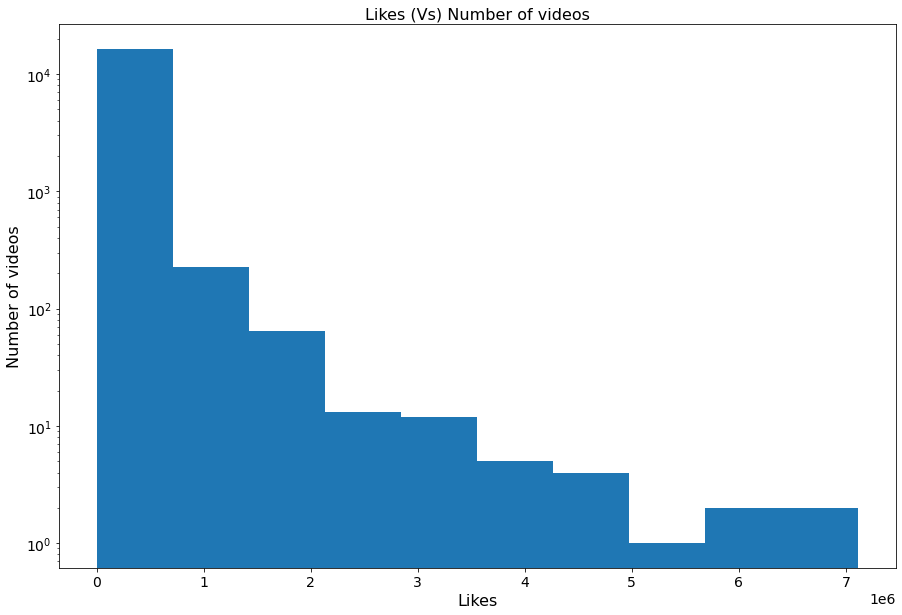

time: 805 ms (started: 2021-12-10 18:56:50 +00:00)


In [25]:
# Histogram for X: Number of likes (Vs) Y: number of Videos per bin/bucket.

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(15,10))
ax.hist(VDFHIST1_1AOUT)
ax.set_title("Likes (Vs) Number of videos")
ax.set_xlabel('Likes')
ax.set_ylabel('Number of videos')
plt.yscale('log')
plt.show()


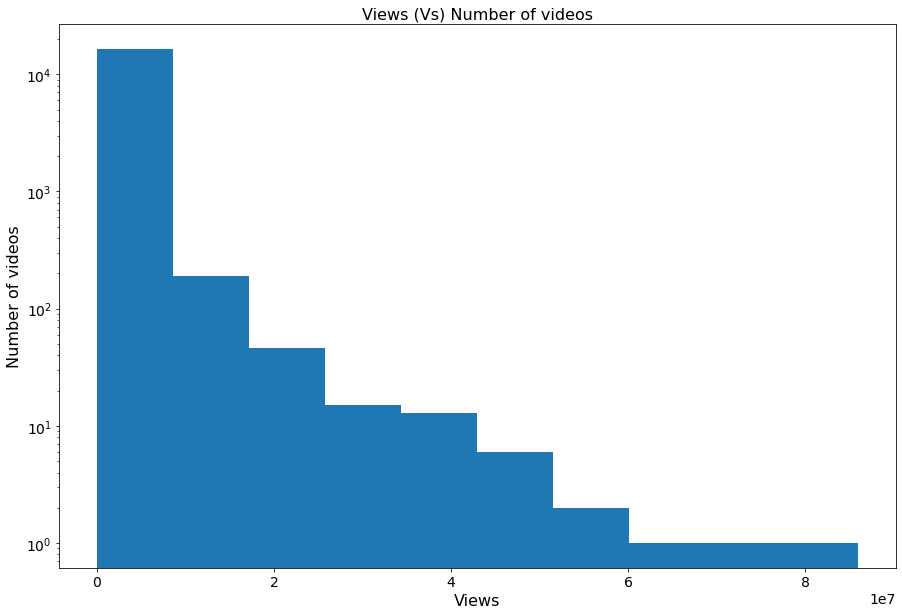

time: 14.9 s (started: 2021-12-10 18:56:51 +00:00)


In [26]:
# Histogram for X: Number of Views (Vs) Y: number of videos per bin/bucket.
VDFHIST1VIEW_1A = maxviewsdf_1a.select("view_count").orderBy("view_count", ascending=False)
VDFHIST1VIEW_1AOUT = [data[0] for data in VDFHIST1VIEW_1A.select('view_count').collect()]

fig, ax = plt.subplots(figsize=(15,10))
ax.hist(VDFHIST1VIEW_1AOUT)
ax.set_title("Views (Vs) Number of videos")
ax.set_xlabel('Views')
ax.set_ylabel('Number of videos')
plt.yscale('log')
plt.show()

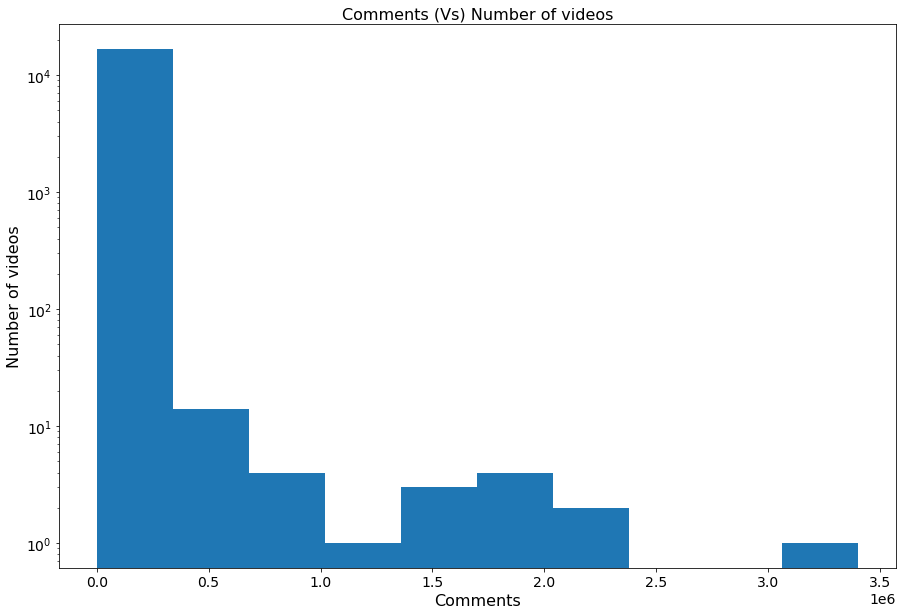

time: 14.6 s (started: 2021-12-10 18:57:06 +00:00)


In [27]:
# Histogram for X: Number of Comments (Vs) Y: number of videos per bin/bucket.
VDFHIST1COMM_1A = maxcommentsdf_1a.select("comment_count").orderBy("comment_count", ascending=False)
VDFHIST1COMM_1AOUT = [data[0] for data in VDFHIST1COMM_1A.select('comment_count').collect()]

fig, ax = plt.subplots(figsize=(15,10))
ax.hist(VDFHIST1COMM_1AOUT)
ax.set_title("Comments (Vs) Number of videos")
ax.set_xlabel('Comments')
ax.set_ylabel('Number of videos')
plt.yscale('log')
plt.show()

In [28]:
# b) How long does it take a Video to become trending for the first time? Videos from which category has a longer trend? 
inputdf_1b = finaldf_1a.withColumn("publishedDate", expr("date(publishedAt)")).withColumn("timetakentotrend", expr("trending_date - publishedDate"))\
             .where(col("timetakentotrend").isNotNull()).withColumn("timetakentotrend",col("timetakentotrend").cast(StringType())).drop("channelId","comments_disabled","ratings_disabled")

split_timetaken_1b = F.split(inputdf_1b['timetakentotrend'], ' ')

daystakentotrenddf_1b = inputdf_1b.withColumn("daystakentotrend", split_timetaken_1b.getItem(0))\
            .withColumn("daystakentotrend",col("daystakentotrend").cast(IntegerType())).drop("timetakentotrend","")

maxdaystotrenddf_1b = daystakentotrenddf_1b.orderBy("daystakentotrend", ascending=False)
## Maximum it took 27 days for a video to trend from its publish date. (3 videos : All from Walmart)
print("====== Maximum it took "+ str(maxdaystotrenddf_1b.collect()[0][11]) + " days for a video to trend from its publish date. ======")
maxdaystotrenddf_1b.show(4, truncate=False)

## 1087 videos Started trending on same day as Published.
zerodaystotrenddf_1b = daystakentotrenddf_1b.where(col("daystakentotrend") == 0)
print("====== "+ str(zerodaystotrenddf_1b.count()) + " videos Started trending on same day as Published. ======")
zerodaystotrenddf_1b.show(5)
#zerodaystotrenddf_1b.count()

## Trending videos from Category ID 22 ("People & Blogs") took longer time to trend compared to other categories.
longertrendbycatdf_1b = daystakentotrenddf_1b.groupBy("categoryId").agg(F.avg("daystakentotrend"))\
                        .withColumnRenamed("avg(daystakentotrend)", "avg_daystakentotrend").orderBy("avg_daystakentotrend", ascending=False)

# Add Category Name from JASON File
categorynamedf_1b = ytvusjdf.join(longertrendbycatdf_1b, (longertrendbycatdf_1b.categoryId == ytvusjdf.id))\
                    .drop("id").orderBy("avg_daystakentotrend", ascending=False)
print("====== Trending videos from Category : "+ str(categorynamedf_1b.collect()[0][0]) + " took longer time to trend compared to other categories. ======")
categorynamedf_1b.show(20, truncate=False)


====== Maximum it took 27 days for a video to trend from its publish date. ======
+-----------+-----------------------------------------------------------+-------------------+------------+----------+-------------+-----------+-------+--------+-------------+-------------+----------------+
|video_id   |title                                                      |publishedAt        |channelTitle|categoryId|trending_date|view_count |likes  |dislikes|comment_count|publishedDate|daystakentotrend|
+-----------+-----------------------------------------------------------+-------------------+------------+----------+-------------+-----------+-------+--------+-------------+-------------+----------------+
|TR0I0STLyws|A different kind of membership. Walmart+ | Mobile scan & go|2020-09-15 13:00:11|Walmart     |22        |2020-10-12   |117988.0   |410.0  |283.0   |0.0          |2020-09-15   |27              |
|izVdUXx5zaU|Walmart Back to College | However you study                |2020-08-06 17:10:23|W

In [29]:
# b) How long does it take a Video to become trending for the first time? Videos from which category has a longer trend? 
inputdf_1b = finaldf_1a.withColumn("publishedDate", expr("date(publishedAt)")).withColumn("timetakentotrend", expr("trending_date - publishedDate"))\
             .where(col("timetakentotrend").isNotNull()).withColumn("timetakentotrend",col("timetakentotrend").cast(StringType())).drop("channelId","comments_disabled","ratings_disabled")

split_timetaken_1b = F.split(inputdf_1b['timetakentotrend'], ' ')

daystakentotrenddf_1b = inputdf_1b.withColumn("daystakentotrend", split_timetaken_1b.getItem(0))\
            .withColumn("daystakentotrend",col("daystakentotrend").cast(IntegerType())).drop("timetakentotrend", "publishedAt")

maxdaystotrenddf_1b = daystakentotrenddf_1b.orderBy("daystakentotrend", ascending=False)
## Maximum it took 27 days for a video to trend from its publish date. (3 videos : All from Walmart)
print("====== Maximum it took "+ str(maxdaystotrenddf_1b.collect()[0][10]) + " days for a video to trend from its publish date. ======")
maxdaystotrenddf_1b.show(4, truncate=False)

## 1087 videos Started trending on same day as Published.
zerodaystotrenddf_1b = daystakentotrenddf_1b.where(col("daystakentotrend") == 0)
print("====== "+ str(zerodaystotrenddf_1b.count()) + " videos Started trending on same day as Published. ======")
zerodaystotrenddf_1b.show(5)
#zerodaystotrenddf_1b.count()

## Trending videos from Category ID 22 ("People & Blogs") took longer time to trend compared to other categories.
longertrendbycatdf_1b = daystakentotrenddf_1b.groupBy("categoryId").agg(F.avg("daystakentotrend"))\
                        .withColumnRenamed("avg(daystakentotrend)", "avg_daystakentotrend").orderBy("avg_daystakentotrend", ascending=False)

# Add Category Name from JASON File
categorynamedf_1b = ytvusjdf.join(longertrendbycatdf_1b, (longertrendbycatdf_1b.categoryId == ytvusjdf.id))\
                    .drop("id").orderBy("avg_daystakentotrend", ascending=False)
print("====== Trending videos from Category : "+ str(categorynamedf_1b.collect()[0][0]) + " took longer time to trend compared to other categories. ======")
categorynamedf_1b.show(20, truncate=False)


====== Maximum it took 27 days for a video to trend from its publish date. ======
+-----------+-----------------------------------------------------------+------------+----------+-------------+-----------+-------+--------+-------------+-------------+----------------+
|video_id   |title                                                      |channelTitle|categoryId|trending_date|view_count |likes  |dislikes|comment_count|publishedDate|daystakentotrend|
+-----------+-----------------------------------------------------------+------------+----------+-------------+-----------+-------+--------+-------------+-------------+----------------+
|TR0I0STLyws|A different kind of membership. Walmart+ | Mobile scan & go|Walmart     |22        |2020-10-12   |117988.0   |410.0  |283.0   |0.0          |2020-09-15   |27              |
|izVdUXx5zaU|Walmart Back to College | However you study                |Walmart     |22        |2020-09-02   |1205139.0  |24.0   |19.0    |16.0         |2020-08-06   |27    

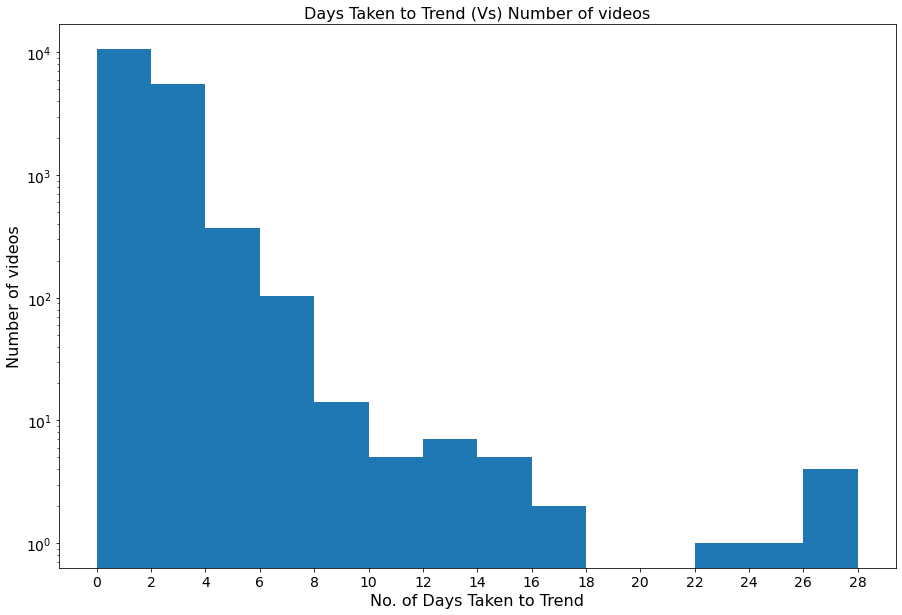

time: 11.5 s (started: 2021-12-10 18:59:20 +00:00)


In [30]:
#Histogram for X: No of Days Taken to Trend (Vs) Y: number of videos per bin/bucket.
VDFHIST1DAYS_1B = daystakentotrenddf_1b.select("daystakentotrend").orderBy("daystakentotrend", ascending=False)
VDFHIST1DAYS_1BOUT = [data[0] for data in VDFHIST1DAYS_1B.select('daystakentotrend').collect()]

fig, ax = plt.subplots(figsize=(15,10))
ax.hist(VDFHIST1DAYS_1BOUT, bins = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])
ax.set_title("Days Taken to Trend (Vs) Number of videos")
ax.set_xlabel('No. of Days Taken to Trend')
ax.set_ylabel('Number of videos')
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])
plt.yscale('log')
plt.show()

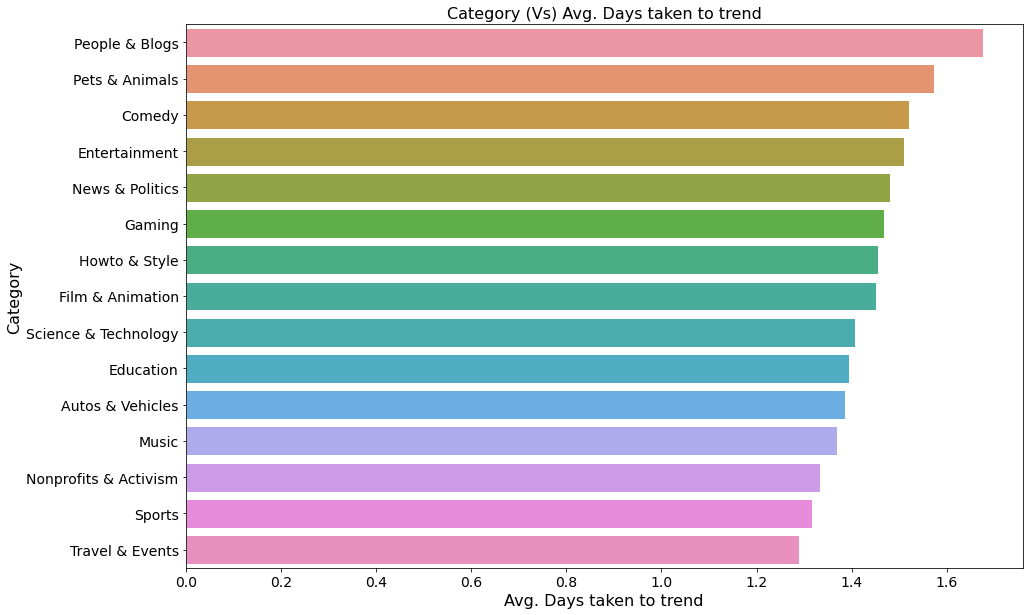

time: 25.4 s (started: 2021-12-10 18:59:31 +00:00)


In [31]:
# Bar Plot for 1B : Category (Vs) Avg. Days taken to trend
import numpy as np
import matplotlib.pyplot as plt

VDFBAR1_1B = categorynamedf_1b.select("Category")
VDFBAR1_1BOUT = [data[0] for data in VDFBAR1_1B.select('Category').collect()]
#print(VDFBAR1_1BOUT)

VDFBAR2_1B = categorynamedf_1b.select("avg_daystakentotrend")
VDFBAR2_1BOUT = [data[0] for data in VDFBAR2_1B.select('avg_daystakentotrend').collect()]
#print(VDFBAR2_1BOUT)

fig, ax = plt.subplots(figsize=(15,10))
#ax.bar(VDFBAR1_1BOUT,VDFBAR2_1BOUT)
sns.set_style("whitegrid")
ax = sns.barplot(y=VDFBAR1_1BOUT,x=VDFBAR2_1BOUT,orient="h")
ax.set_title("Category (Vs) Avg. Days taken to trend")
ax.set_xlabel('Avg. Days taken to trend')
ax.set_ylabel('Category')
plt.show()

In [32]:
# c) What percentage of trending Videos have more Dislikes than Likes? (Negative publicity inference) 

# On 16455 First time trending videos 
popularbutnotlikeddf_1c = finaldf_1a.where(expr("dislikes - likes") > 0)
## 59 / 16455 = Only 0.36 % Videos have more Dislikes than likes when they first became trending.
print("====== "+ str(popularbutnotlikeddf_1c.count()) + " Videos out of "+ str(finaldf_1a.count()) +" i.e. Only 0.36% Videos have more Dislikes than likes when they first became trending. ======")
popularbutnotlikeddf_1c.count() # 59
# finaldf_1a.count() # 16455


# On all 91791 videos 
## 363/91791 = 0.395 of total Videos have more Dislikes than likes.
totalnotlikeddf_1c = cleandf_1a.where(expr("dislikes - likes") > 0)
print("====== "+ str(totalnotlikeddf_1c.count()) +" Videos out of "+ str(cleandf_1a.count()) + " i.e. Only 0.395% of total Videos have more Dislikes than likes. ======")
totalnotlikeddf_1c.count() # 363
# cleandf_1a.count() # 91791


====== 60 Videos out of 16728 i.e. Only 0.36% Videos have more Dislikes than likes when they first became trending. ======
====== 363 Videos out of 91791 i.e. Only 0.395% of total Videos have more Dislikes than likes. ======


363

time: 29.9 s (started: 2021-12-10 18:59:57 +00:00)


In [33]:
# d) Which category of Video becomes most trending? Users like videos from which CATEGORY the most? 

# Which category of Video becomes most trending?
categorydf_1d = cleandf_1a.select("categoryId").withColumn("count", expr("1")).groupBy("categoryId").agg(F.sum("count"))\
                 .withColumnRenamed("sum(count)","count")

# Add Category Name from JASON File
categorynamedf_1d = ytvusjdf.join(categorydf_1d, (categorydf_1d.categoryId == ytvusjdf.id))\
                    .drop("id").orderBy("count", ascending=False)

## Ofcourse "Entertainment" Category (24) becomes more trending with 18373 trending videos count
## "Nonprofits & Activism" Category (29) stands least with 88 trending videos count
cat1dcount = categorynamedf_1d.count()
print("====== Ofcourse "+ str(categorynamedf_1d.collect()[0][0]) + " Category (24) becomes more trending with "+ str(categorynamedf_1d.collect()[0][2]) +" trending videos count ======")
print("====== "+str(categorynamedf_1d.collect()[cat1dcount-1][0]) + " Category (29) stands least with "+ str(categorynamedf_1d.collect()[cat1dcount-1][2]) +" trending videos count ======")
categorynamedf_1d.show(cat1dcount, truncate=False)

====== Ofcourse Entertainment Category (24) becomes more trending with 18373 trending videos count ======
====== Nonprofits & Activism Category (29) stands least with 88 trending videos count ======
+---------------------+----------+-----+
|Category             |categoryId|count|
+---------------------+----------+-----+
|Entertainment        |24        |18373|
|Music                |10        |17053|
|Gaming               |20        |15489|
|Sports               |17        |10093|
|People & Blogs       |22        |7845 |
|Comedy               |23        |4997 |
|Film & Animation     |1         |3511 |
|News & Politics      |25        |3400 |
|Science & Technology |28        |3371 |
|Howto & Style        |26        |3039 |
|Education            |27        |2003 |
|Autos & Vehicles     |2         |1650 |
|Pets & Animals       |15        |494  |
|Travel & Events      |19        |385  |
|Nonprofits & Activism|29        |88   |
+---------------------+----------+-----+

time: 8.01 s (started

Text(0.5, 1.0, 'Catogories of trend videos in US')

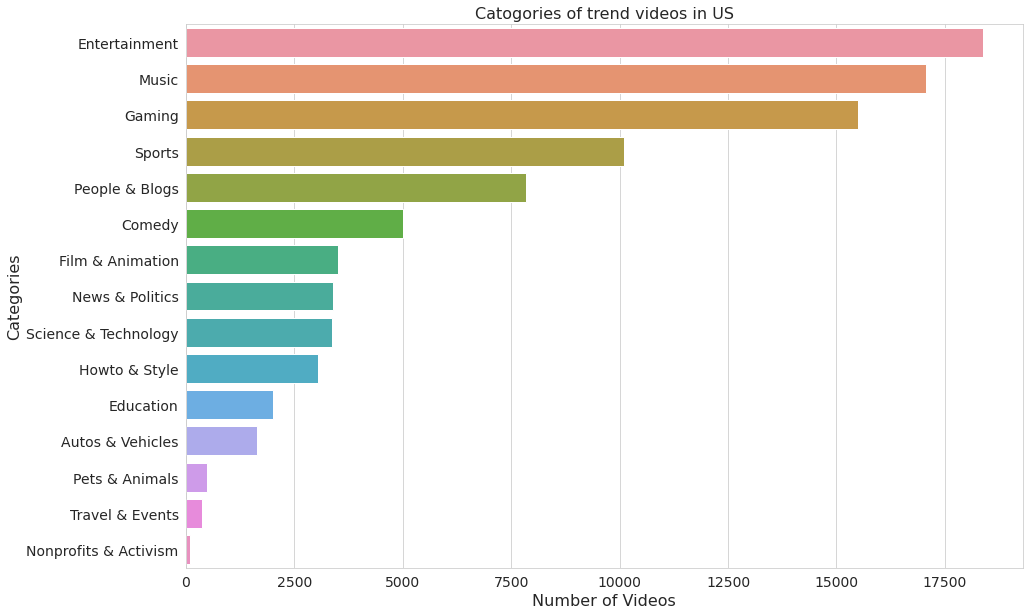

time: 6.87 s (started: 2021-12-10 19:00:35 +00:00)


In [34]:
##Plot for Which category of Video becomes most trending?

VDFBAR1_1D = categorynamedf_1d.select("Category")
VDFBAR1_1DOUT = [data[0] for data in VDFBAR1_1D.select('Category').collect()]
#print(VDFBAR1_1BOUT)

VDFBAR2_1D = categorynamedf_1d.select("count")
VDFBAR2_1DOUT = [data[0] for data in VDFBAR2_1D.select('count').collect()]
#print(VDFBAR2_1BOUT)

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=VDFBAR1_1DOUT,x=VDFBAR2_1DOUT,orient="h")
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Catogories of trend videos in US")

In [35]:
#Users like videos from which CATEGORY the most?

likesbyCatergorydf_1d = cleandf_1a.select("categoryId", "likes").groupBy("categoryId").agg(F.avg("likes"))\
                        .withColumnRenamed("avg(likes)","Avg_likes")
likesbyCatergorynamedf_1d = ytvusjdf.join(likesbyCatergorydf_1d, (likesbyCatergorydf_1d.categoryId == ytvusjdf.id))\
                           .drop("id").orderBy("Avg_likes", ascending=False)
## "Music" Category(10) has highest avg of likes (~324052) and "News & Politics" with least avg of likes (22934)
cat1dlikescount = likesbyCatergorynamedf_1d.count()
print("====== "+ str(likesbyCatergorynamedf_1d.collect()[0][0]) + " Category("+ str(likesbyCatergorynamedf_1d.collect()[0][1]) +") has highest avg of likes ======")
print("====== "+ str(likesbyCatergorynamedf_1d.collect()[cat1dlikescount-1][0]) + " Category("+ str(likesbyCatergorynamedf_1d.collect()[cat1dlikescount-1][1]) +") with least avg of likes ======")
likesbyCatergorynamedf_1d.show(cat1dlikescount, truncate=False)

dislikesbyCatergorydf_1d = cleandf_1a.select("categoryId", "dislikes").groupBy("categoryId").agg(F.avg("dislikes"))\
                        .withColumnRenamed("avg(dislikes)","dislikes")
dislikesbyCatergorynamedf_1d = ytvusjdf.join(dislikesbyCatergorydf_1d, (dislikesbyCatergorydf_1d.categoryId == ytvusjdf.id))\
                           .drop("id").orderBy("dislikes", ascending=False)
cat1ddislikescount = likesbyCatergorynamedf_1d.count()
## "Music" Category(10) has highest avg of dislikes also (~6068) and "Pets & Animals" with least avg of dislikes (743)
print("====== "+ str(dislikesbyCatergorynamedf_1d.collect()[0][0]) + " Category("+ str(dislikesbyCatergorynamedf_1d.collect()[0][1]) +") has highest avg of dislikes also ======")
print("====== "+ str(dislikesbyCatergorynamedf_1d.collect()[cat1ddislikescount-1][0]) + " Category("+ str(dislikesbyCatergorynamedf_1d.collect()[cat1ddislikescount-1][1]) +") with least avg of dislikes ======")
dislikesbyCatergorynamedf_1d.show(cat1ddislikescount, truncate=False)


====== Music Category(10) has highest avg of likes ======
====== News & Politics Category(25) with least avg of likes ======
+---------------------+----------+------------------+
|Category             |categoryId|Avg_likes         |
+---------------------+----------+------------------+
|Music                |10        |324052.5737406908 |
|Entertainment        |24        |167267.7152343112 |
|People & Blogs       |22        |132811.45086042065|
|Gaming               |20        |128413.86868099943|
|Nonprofits & Activism|29        |126097.29545454546|
|Comedy               |23        |122843.45827496499|
|Science & Technology |28        |115669.24592109167|
|Film & Animation     |1         |100102.31643406437|
|Education            |27        |95534.7668497254  |
|Howto & Style        |26        |70824.82856202699 |
|Pets & Animals       |15        |58516.96963562753 |
|Sports               |17        |51975.609531358365|
|Autos & Vehicles     |2         |51397.65393939394 |
|Travel & E

Text(0.5, 1.0, 'Catogories Vs Likes of trend videos in US')

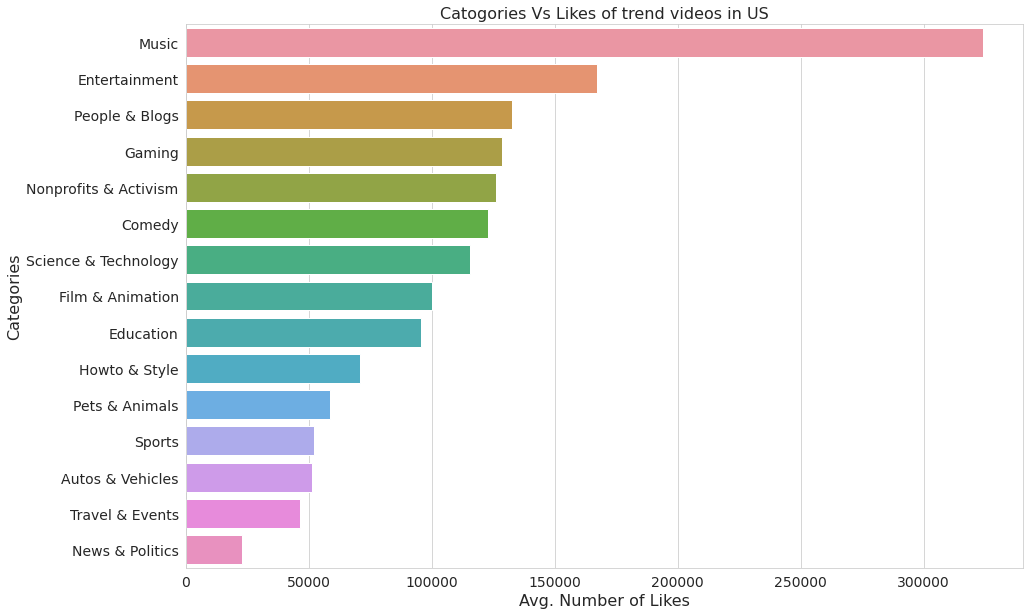

time: 7.15 s (started: 2021-12-10 19:00:58 +00:00)


In [36]:
##Plot for Users like videos from which CATEGORY the most?
import seaborn as sns

VDFBAR3_1D = likesbyCatergorynamedf_1d.select("Category")
VDFBAR3_1DOUT = [data[0] for data in VDFBAR3_1D.select('Category').collect()]
#print(VDFBAR1_1BOUT)

VDFBAR4_1D = likesbyCatergorynamedf_1d.select("Avg_likes")
VDFBAR4_1DOUT = [data[0] for data in VDFBAR4_1D.select('Avg_likes').collect()]
#print(VDFBAR2_1BOUT)

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=VDFBAR3_1DOUT,x=VDFBAR4_1DOUT,orient="h")
plt.xlabel("Avg. Number of Likes")
plt.ylabel("Categories")
plt.title("Catogories Vs Likes of trend videos in US")

In [37]:
# e) Which channels produced more trending videos? 

Channelvidcountdf_1e = cleandf_1a.select("channelId", "channelTitle").withColumn("count", expr("1"))\
                      .groupBy("channelId", "channelTitle").agg(F.sum("count")).withColumnRenamed("channelId","channel_Id")\
                      .withColumnRenamed("sum(count)","count").orderBy("count", ascending=False)

## "NBA" channel (with Channel ID: UCWJ2lWNubArHWmf3FIHbfcQ) has hosted highest trending videos (578).
channel1ecount = Channelvidcountdf_1e.count()
print("====== "+ str(Channelvidcountdf_1e.collect()[0][1]) + " channel(with Channel ID:"+ str(Channelvidcountdf_1e.collect()[0][0]) +") has hosted highest trending videos " + str(Channelvidcountdf_1e.collect()[0][2]) +" ======")
Channelvidcountdf_1e.show(2, truncate=False)

## 41 channels has only 1 video trending and only on one day.
Channelonevideodf_1e = Channelvidcountdf_1e.filter(col("count") == "1")
print("====== "+ str(Channelonevideodf_1e.count()) + " channels has only "+ str(Channelonevideodf_1e.collect()[0][2]) +" video trending and only on one day. ======")
Channelonevideodf_1e.show(2, truncate=False)


====== NBA channel(with Channel ID:UCWJ2lWNubArHWmf3FIHbfcQ) has hosted highest trending videos 578 ======
+------------------------+------------+-----+
|channel_Id              |channelTitle|count|
+------------------------+------------+-----+
|UCWJ2lWNubArHWmf3FIHbfcQ|NBA         |578  |
|UCDVYQ4Zhbm3S2dlz7P1GBDg|NFL         |572  |
+------------------------+------------+-----+
only showing top 2 rows

====== 41 channels has only 1 video trending and only on one day. ======
+------------------------+-------------------+-----+
|channel_Id              |channelTitle       |count|
+------------------------+-------------------+-----+
|UC1JOnWZrVWKzX3UMdpnvuMg|Paradox Interactive|1    |
|UCfrSUhUYOUyZROqWZb-TphQ|adidas Originals   |1    |
+------------------------+-------------------+-----+
only showing top 2 rows

time: 17.2 s (started: 2021-12-10 19:01:05 +00:00)


In [38]:
# f) How many videos appeared trending for most of the days?

## Correlation between Days of Publish to Trend (v/s) Trending Duration.

df3 = usadf.where(col("Description").isNotNull()).withColumn("publishedAt",F.to_timestamp(col("publishedAt"))).\
withColumn("trending_date",F.to_timestamp(col("trending_date"))).\
withColumn("Date Diff",F.datediff(col("trending_date"),col("publishedAt"))).\
groupby(col("video_id")).agg(F.min("Date Diff"),F.count("Date Diff")).\
withColumnRenamed("min(Date Diff)","Days to Trend").\
withColumnRenamed("count(Date Diff)","Trending Duration")

time: 101 ms (started: 2021-12-10 19:01:22 +00:00)


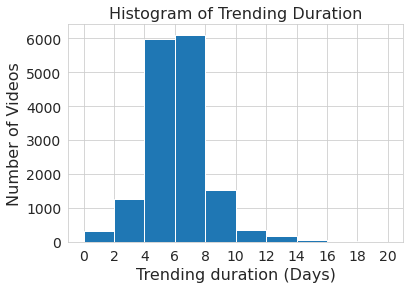

time: 3.49 s (started: 2021-12-10 19:01:23 +00:00)


In [39]:
## Plot for 1f : How many videos appeared trending for most of the days?
trendingHist = [data[0] for data in df3.select('Trending Duration').collect()]

from matplotlib import pyplot as plt
import numpy as np
fig,ax = plt.subplots(1,1)

ax.hist(trendingHist, bins = [0,2,4,6,8,10,12,14,16,18,20])
ax.set_title("Histogram of Trending Duration")
ax.set_xlabel('Trending duration (Days)')
ax.set_ylabel('Number of Videos')
ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20])
plt.show()

In [40]:
# Section 2 -  Starts Here

time: 1.59 ms (started: 2021-12-10 19:01:26 +00:00)


In [41]:
# Section 3  - Starts Here

time: 1.22 ms (started: 2021-12-10 19:01:26 +00:00)


In [42]:
### Helper function for drawing heatmap
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels)
    

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    # ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

time: 79.4 ms (started: 2021-12-10 19:01:26 +00:00)


#### Q3A Find correlation ration between likes-dislikes-view-comment for different categories.


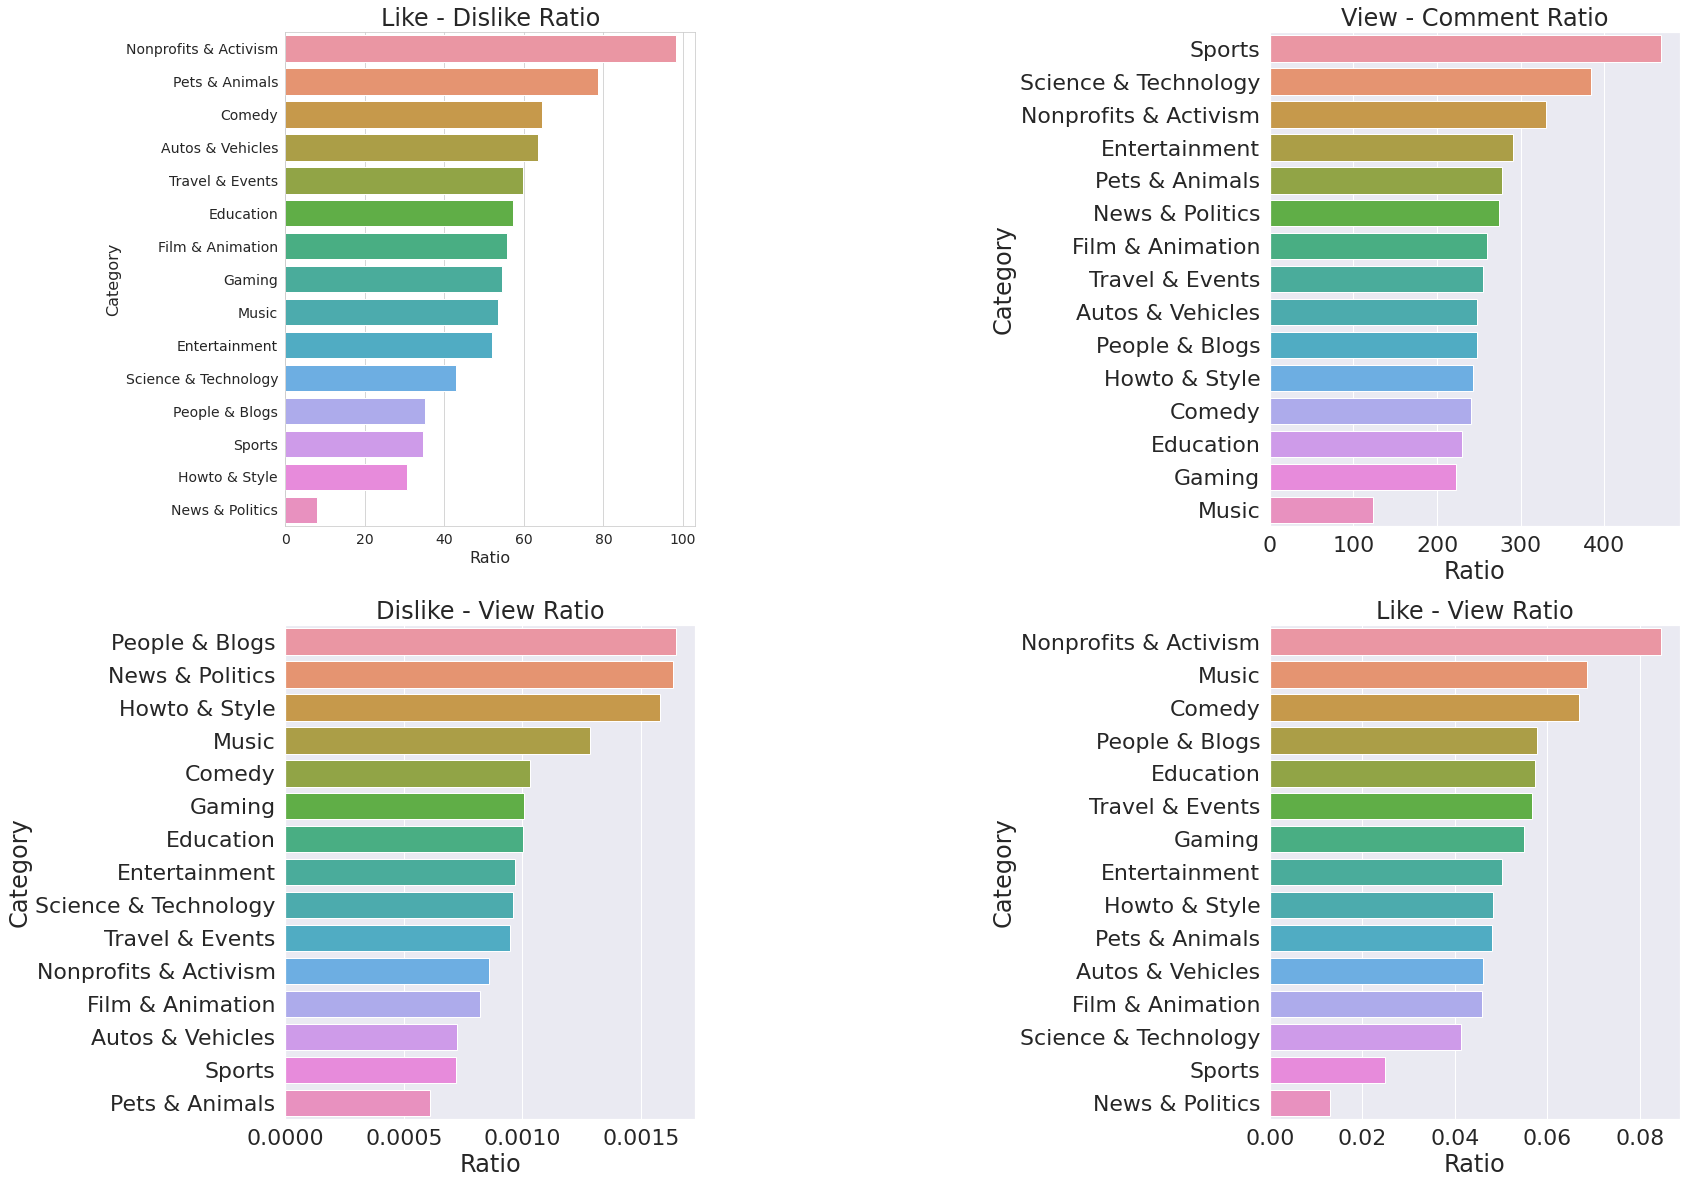

time: 15.6 s (started: 2021-12-10 19:01:26 +00:00)


In [43]:


df11 = usadf.withColumn("view_count",col("view_count").cast("double"))\
.withColumn("likes",col("likes").cast("double"))\
.withColumn("dislikes",col("dislikes").cast("double"))\
.withColumn("comment_count",col("comment_count").cast("double"))\
.withColumn("categoryId",F.col("categoryId").cast("int"))

df22 = df11.groupby('categoryId').sum().withColumn("ratioLikeDisLike",col('sum(likes)')/col('sum(dislikes)')).\
withColumn("ratioViewComment",col('sum(view_count)')/col('sum(comment_count)')).\
withColumn("ratioDisLikeView",col('sum(dislikes)')/col('sum(view_count)')).\
withColumn("ratioLikeView",col('sum(likes)')/col('sum(view_count)'))

df33 = df22.join(ytvusjdf,df22.categoryId == ytvusjdf.id)

def plotData(data_x,data_y,title):
  sns.set_style("whitegrid")
  sns.set(font_scale = 2)
  sns.barplot(x = data_x, y = data_y, orient='h')
  plt.xlabel("Ratio")
  plt.ylabel("Category")
  plt.title(title)

plt.figure(figsize=(25,20))
plt.subplot(231)
x = df33.select(["ratioLikeDisLike","Category"]).sort(["ratioLikeDisLike"],ascending=False).collect()
data_x = [item['ratioLikeDisLike'] for item in x]; data_y = [item['Category'] for item in x]
plotData(data_x,data_y,"Like - Dislike Ratio")

plt.subplot(233)
x = df33.select(["ratioViewComment","Category"]).sort(["ratioViewComment"],ascending=False).collect()
data_x = [item['ratioViewComment'] for item in x]; data_y = [item['Category'] for item in x]
plotData(data_x,data_y, "View - Comment Ratio")

plt.subplot(234)
x = df33.select(["ratioDisLikeView","Category"]).sort(["ratioDisLikeView"],ascending=False).collect()
data_x = [item['ratioDisLikeView'] for item in x]; data_y = [item['Category'] for item in x]
plotData(data_x,data_y,"Dislike - View Ratio")

plt.subplot(236)
x = df33.select(["ratioLikeView","Category"]).sort(["ratioLikeView"],ascending=False).collect()
data_x = [item['ratioLikeView'] for item in x]; data_y = [item['Category'] for item in x]
plotData(data_x,data_y, "Like - View Ratio")

plt.show()

Observations:
1. News & Politics have lowest like-dislike ratio and view-comment ratio. People relatively dislike these videos and comment alot. It also have highest Dislike- view ratio.

2. Pets & Animals videos & Non-profits Videos have highest likes-dislikes ratio. Not suprisingly, people find difficult to hate pets and animals and non-profit activity.

3. Sports and Science Technology have largest view-comment ratio. People tend to comment less on these videos compared to music-related video.





Q 3.B **Correlation between different metrics through Heat map.**

In [44]:
### Get Features
df = usadf.where(col("description").isNotNull()).withColumn("Description length",length("description"))\
.withColumn("Title length",length("title"))\
.withColumn("Tags length",length("tags"))\
.withColumn("# of Tags",size(split(col("tags"),"[|]")))\
.select("view_count","likes","dislikes","comment_count","Description length","Title length","Tags length","# of Tags","categoryId")

### Format data
df1 = df.withColumn("view_count",col("view_count").cast("double"))\
.withColumn("likes",col("likes").cast("double"))\
.withColumn("dislikes",col("dislikes").cast("double"))\
.withColumn("comment_count",col("comment_count").cast("double"))\
.withColumn("categoryId",F.col("categoryId").cast("int"))

df2 = df1.where(col("categoryId").isNotNull())

time: 186 ms (started: 2021-12-10 19:01:42 +00:00)


In [45]:
categories = [24,29]

## Convert dataframe into vectors
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df2.columns[:-1], outputCol=vector_col)
  
### Find correlation of every category for the columns specified and store it in dictionary
corr_list = []
for ID in categories:
  # convert to vector column first
  df_vector = assembler.transform(df2.where(col("categoryId") == ID)).select(vector_col)
  # get correlation matrix
  matrix = Correlation.corr(df_vector, vector_col)
  name = ytvusjdf.where(col("id") == ID).select("Category").collect()[0]['Category']
  corr_list.append({"ID":ID,"name":name,"Corr":matrix.collect()[0]['pearson(corr_features)'].values})

time: 8.32 s (started: 2021-12-10 19:01:42 +00:00)


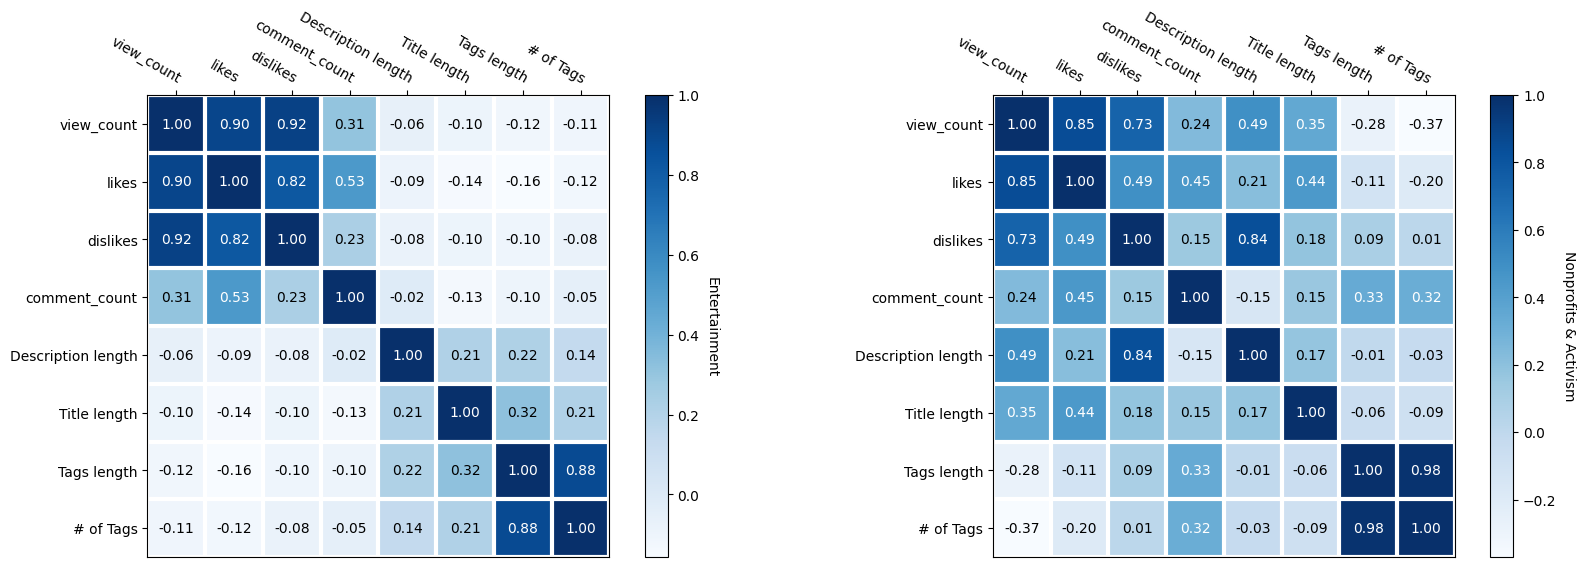

time: 1.69 s (started: 2021-12-10 19:01:50 +00:00)


In [46]:
## Plot the data
sns.reset_defaults()

columns = ["view_count","likes","dislikes","comment_count","Description length","Title length","Tags length","# of Tags"]
plt.figure(figsize=(20,6))
plt.subplot(121)
im, cbar = heatmap(corr_list[0]["Corr"].reshape(len(columns),-1), columns, columns, ax=None, cmap="Blues", cbarlabel=corr_list[0]["name"])
texts = annotate_heatmap(im, valfmt="{x:.2f}")

plt.subplot(122)
im, cbar = heatmap(corr_list[1]["Corr"].reshape(len(columns),-1), columns, columns, ax=None,cmap="Blues", cbarlabel=corr_list[1]["name"])
texts = annotate_heatmap(im, valfmt="{x:.2f}")

plt.show()

Observations:
1. Videos belong to entertainment category shows high correlation among views, likes, dislikes etc. It shows very less correlation with description length, title length etc

2. However, for video which are trending on category like Non-profits and activism, Description length plays an important role.

3. 49% correlation is observed between views and description length and 84% correlation between dislikes and description length.

## Q-3c Correlation between Days of Publish to Trend (v/s) Trending Duration.

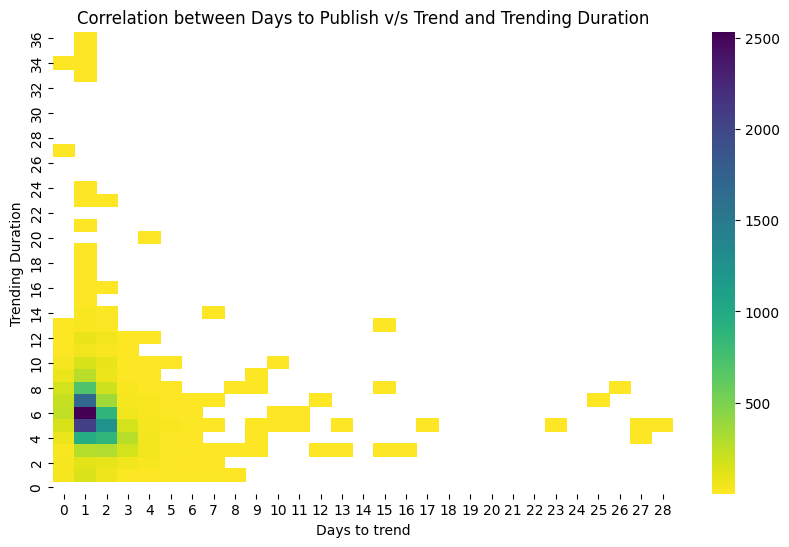

time: 7.41 s (started: 2021-12-10 19:01:52 +00:00)


In [47]:

## Get features
df3 = usadf.where(col("Description").isNotNull()).withColumn("publishedAt",F.to_timestamp(col("publishedAt"))).\
withColumn("trending_date",F.to_timestamp(col("trending_date"))).\
withColumn("Date Diff",F.datediff(col("trending_date"),col("publishedAt"))).\
groupby(col("video_id")).agg(F.min("Date Diff"),F.count("Date Diff")).\
withColumnRenamed("min(Date Diff)","Days to Trend").\
withColumnRenamed("count(Date Diff)","Trending Duration")

## Get count
out = df3.groupby("Days to Trend","Trending Duration").count().collect()

## Convert to heatmap array
out1 = np.array([(item['Days to Trend'], item['Trending Duration'], item['count']) for item in out])
out2 = np.zeros((np.max(out1[:,0])+1, np.max(out1[:,1]) + 1)) * np.nan
out2[out1[:,0],out1[:,1]] = out1[:,2]

## Plot data
plt.figure(figsize=(10,6))
ax = sns.heatmap(out2.T, cmap='viridis_r')
ax.invert_yaxis()
plt.title("Correlation between Days to Publish v/s Trend and Trending Duration")
plt.xlabel("Days to trend")
plt.ylabel("Trending Duration")
plt.show()

Observations:

1. The less days needed for a video from publish to trend, the longer the trend duration.

2. Videos that can get into trending within 3 days will have higher probability to be trending for longer time.

#### 3. Correlation between various trending video metrics: [Spark Dataframes]
 ##### d) Does the video trending in one country will trend in other countries too? (for 3 countries)
 1) get the distinct trending video per country.
 
 2) Count the number of trending video matching between US vs GB and US vs IN
 
 3) Derive the analogy.

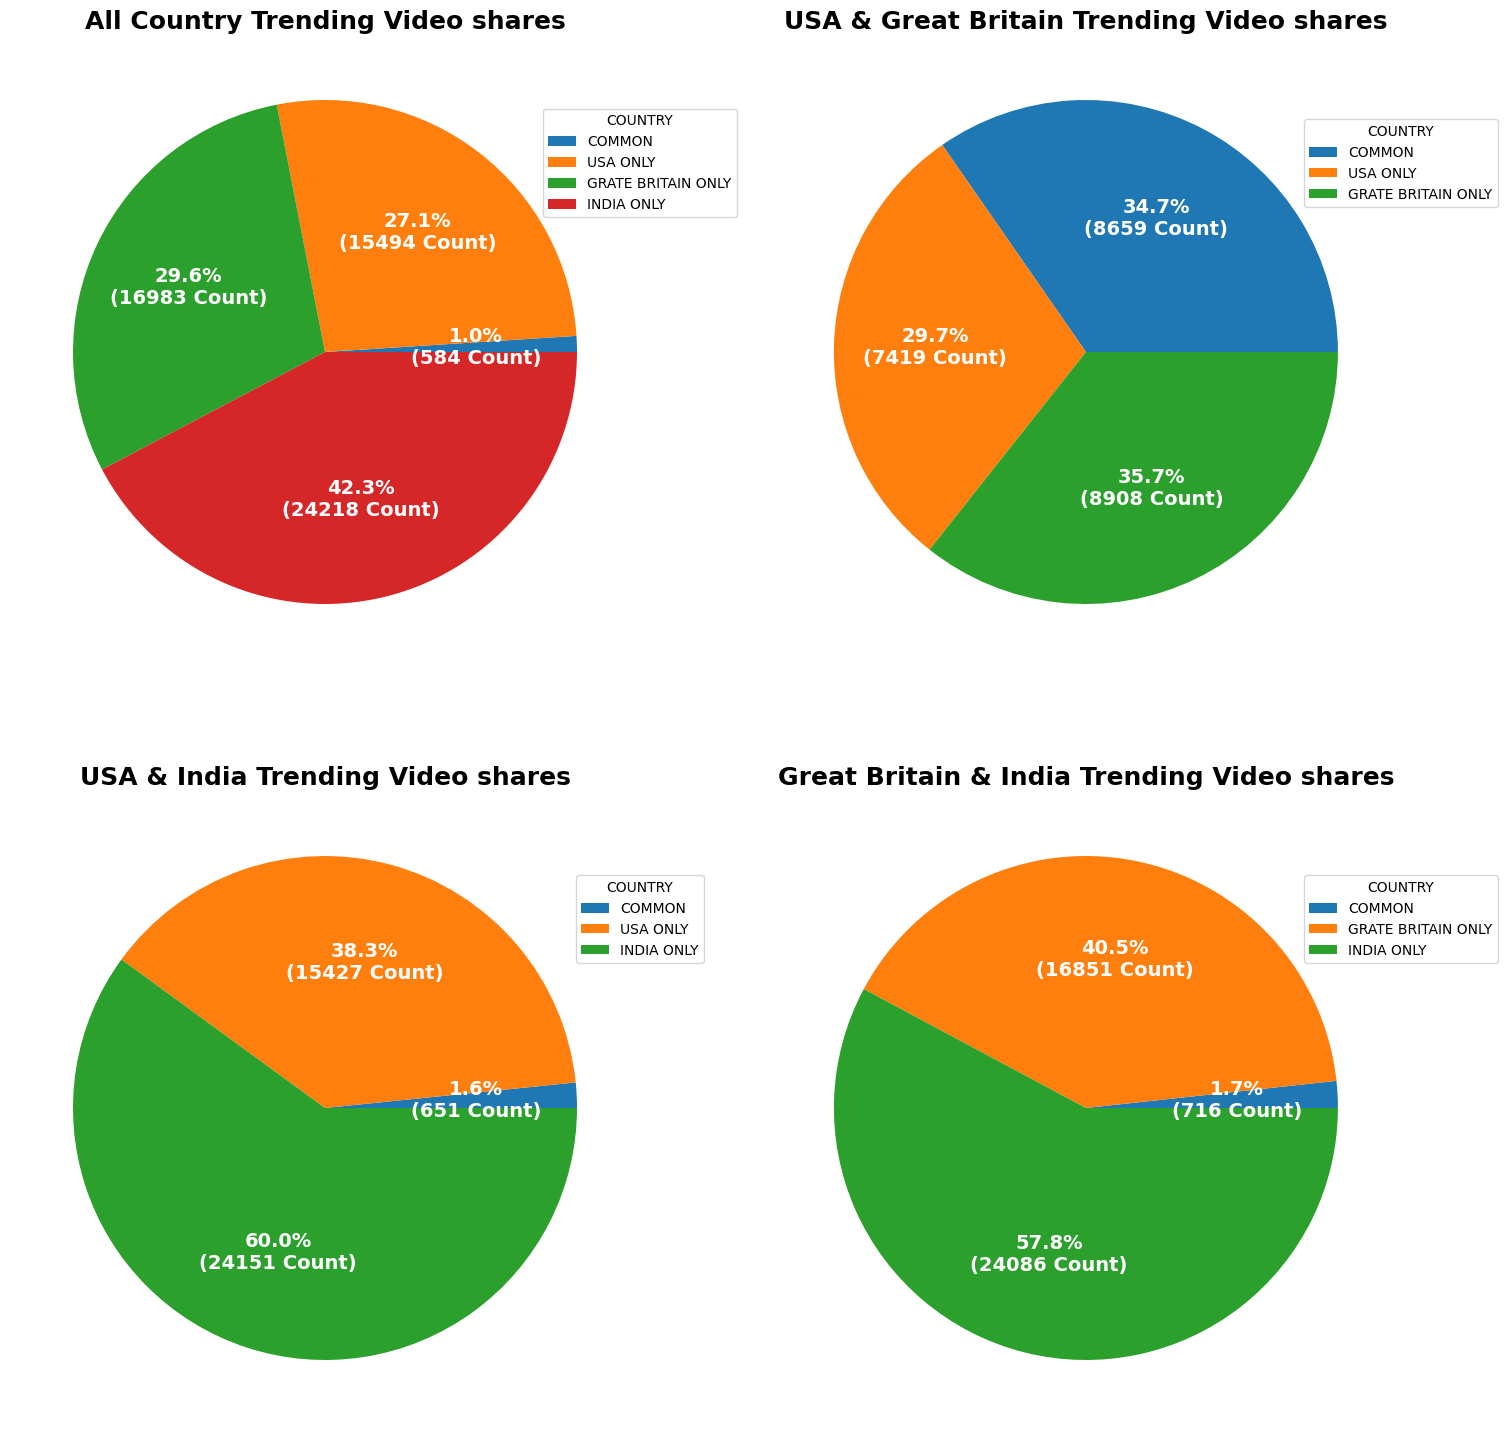

time: 29.7 s (started: 2021-12-10 19:01:59 +00:00)


In [48]:
usDistinctdf = uscdf.select("video_id").distinct()
gbDistinctdf = gbcdf.select("video_id").distinct().withColumnRenamed("video_id","gbvideo_id")
inDistinctdf = incdf.select("video_id").distinct().withColumnRenamed("video_id","invideo_id")

usGbMatchdf = usDistinctdf.join(gbDistinctdf, usDistinctdf.video_id == gbDistinctdf.gbvideo_id).drop("gbvideo_id")
usInMatchdf = usDistinctdf.join(inDistinctdf, usDistinctdf.video_id == inDistinctdf.invideo_id).drop("invideo_id")
gbInMatchdf = gbDistinctdf.join(inDistinctdf, gbDistinctdf.gbvideo_id == inDistinctdf.invideo_id).drop("gbvideo_id")
all3Matchdf = usGbMatchdf.join(inDistinctdf, usGbMatchdf.video_id == inDistinctdf.invideo_id).drop("invideo_id")

usCount = usDistinctdf.count()
gbCount = gbDistinctdf.count()
inCount = inDistinctdf.count()
usGbCount = usGbMatchdf.count()
usInCount = usInMatchdf.count()
gbInCount = gbInMatchdf.count()
allCount = all3Matchdf.count()

fig, ax = plt.subplots(2, 2, figsize=(18, 18), subplot_kw=dict(aspect="equal"))

allCountrydata = [allCount, usCount-allCount, gbCount-allCount, inCount-allCount]
ingredients = ["COMMON", "USA ONLY", "GRATE BRITAIN ONLY", "INDIA ONLY"]

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} Count)".format(pct, absolute)

wedges, texts, autotexts = ax[0][0].pie(allCountrydata, autopct=lambda pct: func(pct, allCountrydata), textprops=dict(color="w"))
ax[0][0].legend(wedges, ingredients, title="COUNTRY", loc="center", bbox_to_anchor=(1, 0.8, 0, 0))
ax[0][0].set_title("All Country Trending Video shares", size=18, weight="bold")
plt.setp(autotexts, size=14, weight="bold")

US_GB_data = [usGbCount, usCount-usGbCount, gbCount-usGbCount]
ingredients1 = ["COMMON", "USA ONLY", "GRATE BRITAIN ONLY"]

wedges, texts, autotexts1 = ax[0][1].pie(US_GB_data, autopct=lambda pct: func(pct, US_GB_data), textprops=dict(color="w"))
ax[0][1].legend(wedges, ingredients1, title="COUNTRY", loc="center", bbox_to_anchor=(1, 0.8, 0, 0))
ax[0][1].set_title("USA & Great Britain Trending Video shares", size=18, weight="bold")
plt.setp(autotexts1, size=14, weight="bold")

US_IN_data = [usInCount, usCount-usInCount, inCount-usInCount]
ingredients2 = ["COMMON", "USA ONLY", "INDIA ONLY"]

wedges, texts, autotexts2 = ax[1][0].pie(US_IN_data, autopct=lambda pct: func(pct, US_IN_data), textprops=dict(color="w"))
ax[1][0].legend(wedges, ingredients2, title="COUNTRY", loc="center", bbox_to_anchor=(1, 0.8, 0, 0))
ax[1][0].set_title("USA & India Trending Video shares", size=18, weight="bold")
plt.setp(autotexts2, size=14, weight="bold")

GB_IN_data = [gbInCount, gbCount-gbInCount, inCount-gbInCount]
ingredients3 = ["COMMON", "GRATE BRITAIN ONLY", "INDIA ONLY"]

wedges, texts, autotexts3 = ax[1][1].pie(GB_IN_data, autopct=lambda pct: func(pct, GB_IN_data), textprops=dict(color="w"))
ax[1][1].legend(wedges, ingredients3, title="COUNTRY", loc="center", bbox_to_anchor=(1, 0.8, 0, 0))
ax[1][1].set_title("Great Britain & India Trending Video shares", size=18, weight="bold")
plt.setp(autotexts3, size=14, weight="bold")

plt.show()
fig.savefig("youTube_Trend.png",dpi=400, bbox_inches='tight')

##### e) Comparison between number of trending videos per category across 3 countries.
 1) Count trending video for each category for 3 country 
 
 2) Prepare Histogram for category wise country video Count for comparision

Text(0.5, 1.0, 'Trending videos category wise - US')

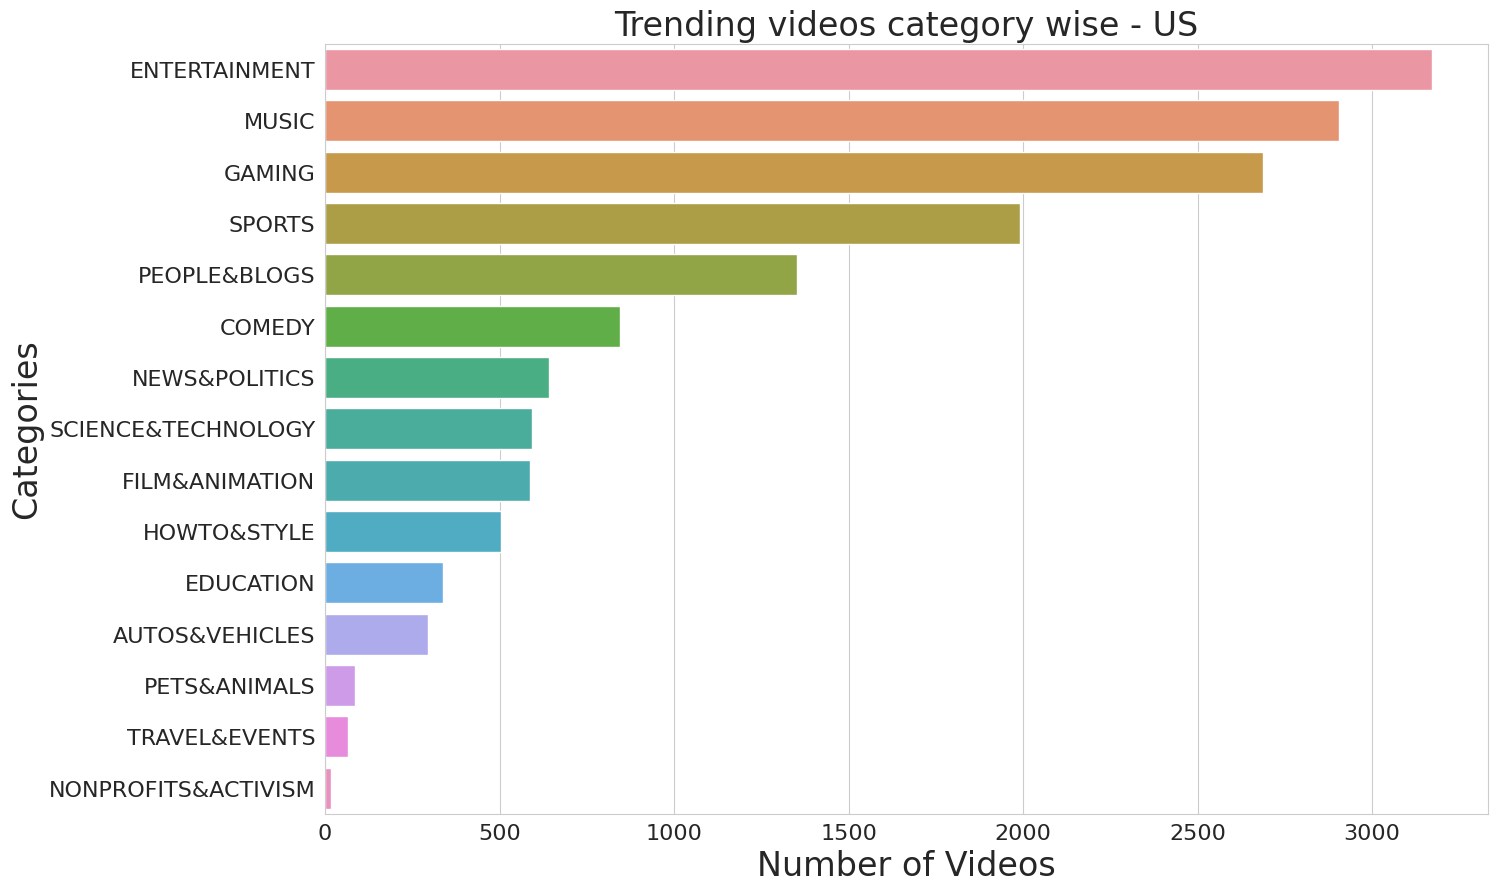

time: 12.4 s (started: 2021-12-10 19:02:29 +00:00)


In [49]:
# Histogram for X: Number of likes (Vs) Y: number of Videos per bin/bucket.

SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

usDropDupDF = uscdf.dropDuplicates(["video_id"])
usCategoryDF = usDropDupDF.join(usjdf, usDropDupDF.categoryId == usjdf.id, "left").select("video_id", upper(col('category')))\
               .withColumnRenamed("upper(category)", "category").na.replace('[NONE]', None).select("video_id", regexp_replace(col("category"), " ", ""))\
               .withColumnRenamed("regexp_replace(category,  , )", "category").groupBy("category").agg(count("category").alias("count")).orderBy("count", ascending=False)

VDFBAR1_1D = usCategoryDF.select("Category")
VDFBAR1_1DOUT = [data[0] for data in VDFBAR1_1D.select('Category').collect()]
#print(VDFBAR1_1BOUT)

VDFBAR2_1D = usCategoryDF.select("count")
VDFBAR2_1DOUT = [data[0] for data in VDFBAR2_1D.select('count').collect()]
#print(VDFBAR2_1BOUT)

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=VDFBAR1_1DOUT,x=VDFBAR2_1DOUT,orient="h")
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Trending videos category wise - US")

Text(0.5, 1.0, 'Trending videos category wise - Great Britain')

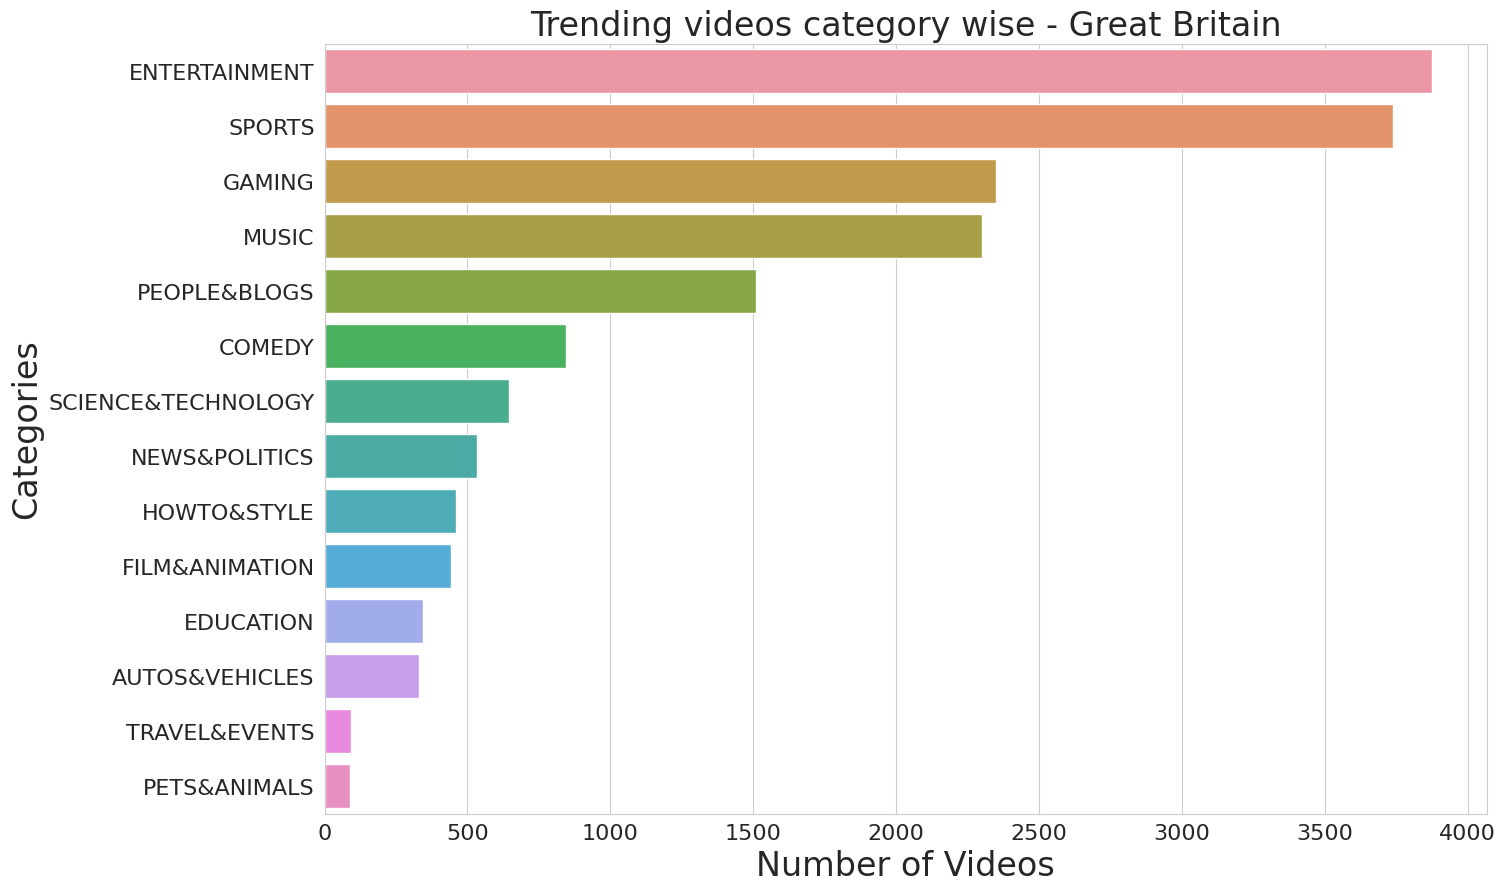

time: 12.1 s (started: 2021-12-10 19:02:42 +00:00)


In [50]:
# Histogram for X: Number of likes (Vs) Y: number of Videos per bin/bucket.

SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

gbDropDupDF = gbcdf.dropDuplicates(["video_id"])
gbCategoryDF = gbDropDupDF.join(gbjdf, gbDropDupDF.categoryId == gbjdf.id, "left").select("video_id", upper(col('category')))\
               .withColumnRenamed("upper(category)", "category").na.replace('[NONE]', None).select("video_id", regexp_replace(col("category"), " ", ""))\
               .withColumnRenamed("regexp_replace(category,  , )", "category").groupBy("category").agg(count("category").alias("count")).orderBy("count", ascending=False)

VDFBAR1_1D = gbCategoryDF.select("Category")
VDFBAR1_1DOUT = [data[0] for data in VDFBAR1_1D.select('Category').collect()]
#print(VDFBAR1_1BOUT)

VDFBAR2_1D = gbCategoryDF.select("count")
VDFBAR2_1DOUT = [data[0] for data in VDFBAR2_1D.select('count').collect()]
#print(VDFBAR2_1BOUT)

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=VDFBAR1_1DOUT,x=VDFBAR2_1DOUT,orient="h")
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Trending videos category wise - Great Britain")

Text(0.5, 1.0, 'Trending videos category wise - India')

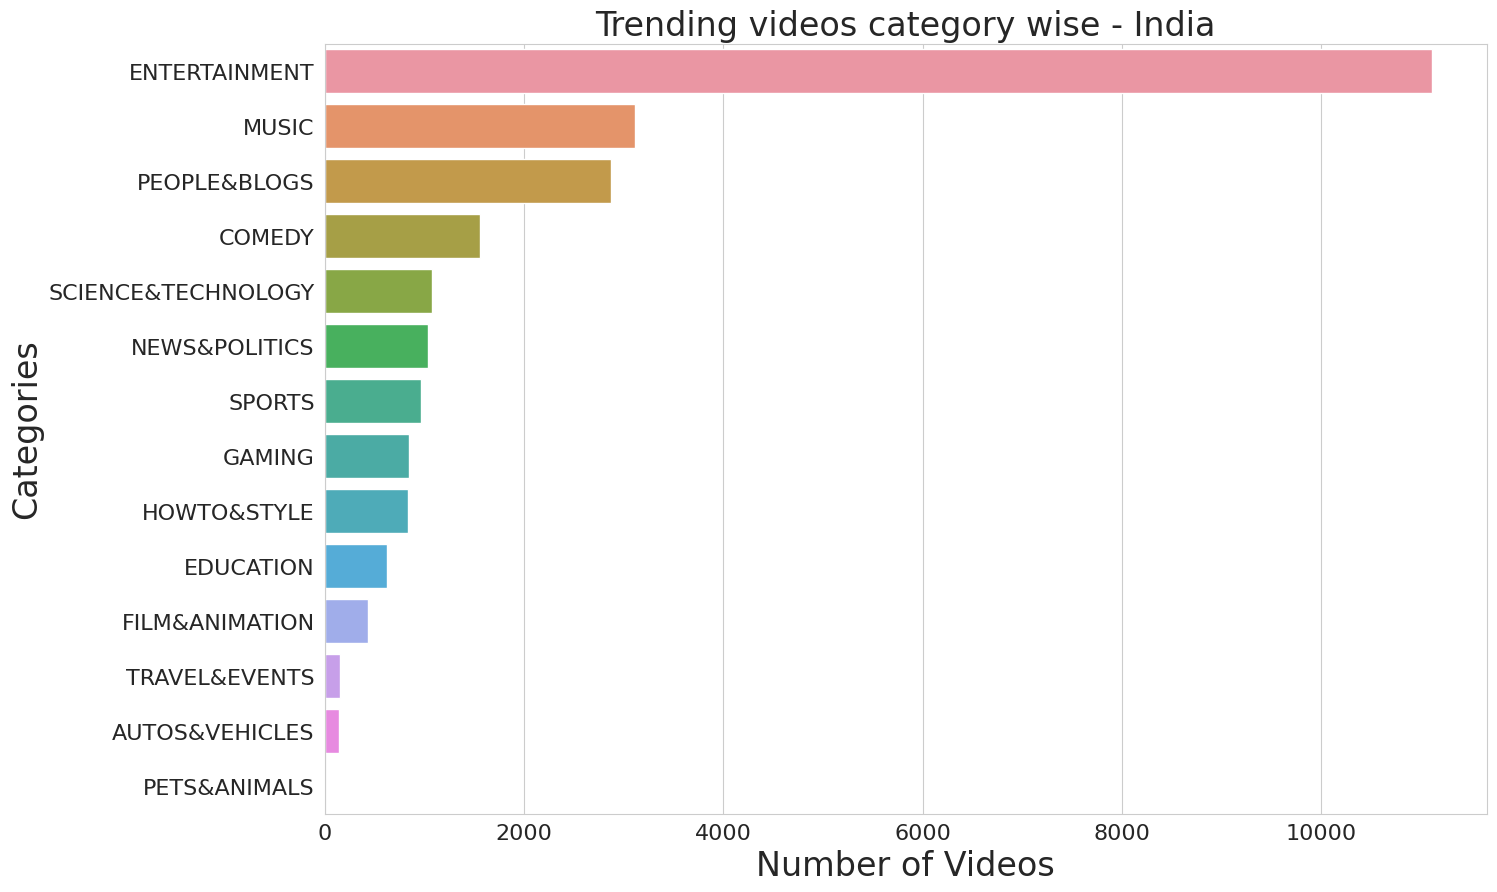

time: 11.9 s (started: 2021-12-10 19:02:54 +00:00)


In [51]:
# Histogram for X: Number of likes (Vs) Y: number of Videos per bin/bucket.

SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 24

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

inDropDupDF = incdf.dropDuplicates(["video_id"])
inCategoryDF = inDropDupDF.join(injdf, inDropDupDF.categoryId == injdf.id, "left").select("video_id", upper(col('category')))\
               .withColumnRenamed("upper(category)", "category").na.replace('[NONE]', None).select("video_id", regexp_replace(col("category"), " ", ""))\
               .withColumnRenamed("regexp_replace(category,  , )", "category").groupBy("category").agg(count("category").alias("count")).orderBy("count", ascending=False)

VDFBAR1_1D = inCategoryDF.select("Category")
VDFBAR1_1DOUT = [data[0] for data in VDFBAR1_1D.select('Category').collect()]
#print(VDFBAR1_1BOUT)

VDFBAR2_1D = inCategoryDF.select("count")
VDFBAR2_1DOUT = [data[0] for data in VDFBAR2_1D.select('count').collect()]
#print(VDFBAR2_1BOUT)

plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=VDFBAR1_1DOUT,x=VDFBAR2_1DOUT,orient="h")
plt.xlabel("Number of Videos")
plt.ylabel("Categories")
plt.title("Trending videos category wise - India")

In [52]:
# Section 4  - Starts Here

time: 969 µs (started: 2021-12-10 19:03:06 +00:00)


In [53]:
DF1 = usadf.select(split(usadf.tags, '[|]').alias("Tag_List"), col("tags"), col("video_id"),col("title"))

#VDF2.show(10)

##Make NULL as 0

DF2 = DF1.withColumn("NumberofTags", size(col("Tag_List")))
DF3 = DF2.withColumn("NumberofValidTags", when(DF2["NumberofTags"] == -1, 0).otherwise(DF2["NumberofTags"]))
DF4 = DF3.select("video_id", "title", "tags", "NumberofValidTags")
DF5 = DF4.agg(avg(col("NumberofValidTags")))
DF4.show(truncate=False)
#DF5.show()

print("Average Number of Tags")
DFHISTTAGS = DF4.select("NumberofValidTags")
DFHISTTAGSOUT = [data[0] for data in DFHISTTAGS.select('NumberofValidTags').collect()]
#print(VDFHIST1OUT)

+-----------+------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|video_id   |title                                                                   |tags                                                                                                                                                                                                                                                                                                                                                

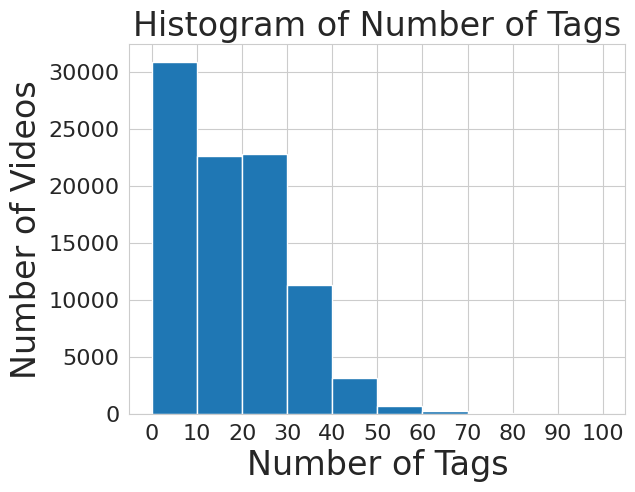

time: 346 ms (started: 2021-12-10 19:03:09 +00:00)


In [54]:
#Histogram Tags Length
from matplotlib import pyplot as plt
import numpy as np
fig,ax = plt.subplots(1,1)
ax.hist(DFHISTTAGSOUT, bins = [0,10,20,30,40,50,60,70,80,90,100])
ax.set_title("Histogram of Number of Tags")
ax.set_xticks([0,10,20,30,40,50,60,70,80,90,100])
ax.set_xlabel('Number of Tags')
ax.set_ylabel('Number of Videos')
plt.show()

In [55]:
#Average Title Number of Words

DF102 = usadf.select(split(usadf.title, ' ').alias("title_List"), col("video_id"),col("title"))
#DF101.show(10)

##Make NULL as 0
DF103 = DF102.withColumn("NumberofWords", size(col("title_List")))
DF104 = DF103.withColumn("NumberofValidWords", when(DF103["NumberofWords"] == -1, 0).otherwise(DF103["NumberofWords"]))
DF105 = DF104.select("video_id", "title", "NumberofValidWords").agg(avg(col("NumberofValidWords")))
#VDF104.show(10)
DF105.show(10)

print("Average Number of Words in Title")
DFHISTTITLEWORDS = DF104.select("NumberofValidWords")
DFHISTTITLEWORDSOUT = [data[0] for data in DFHISTTITLEWORDS.select('NumberofValidWords').collect()]
#print(DFHISTTITLEWORDSOUT)

+-----------------------+
|avg(NumberofValidWords)|
+-----------------------+
|      8.853536839123661|
+-----------------------+

Average Number of Words in Title
time: 3.77 s (started: 2021-12-10 19:03:09 +00:00)


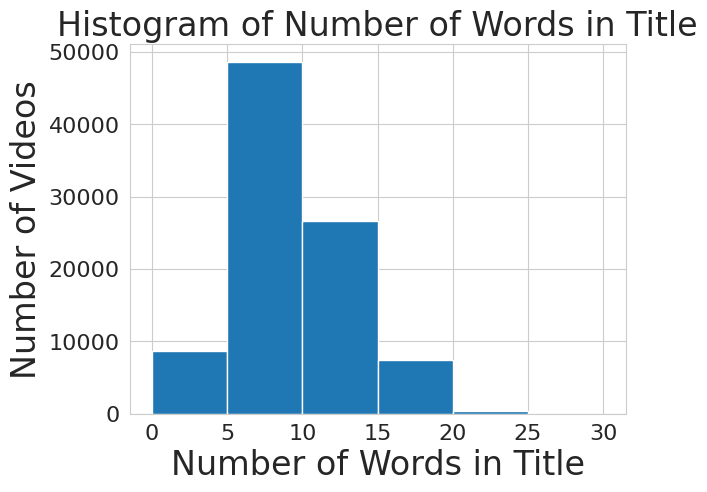

time: 295 ms (started: 2021-12-10 19:03:13 +00:00)


In [56]:
#When NULL Values are made 0
from matplotlib import pyplot as plt
import numpy as np
fig,ax = plt.subplots(1,1)
ax.hist(DFHISTTITLEWORDSOUT, bins = [0,5,10,15,20,25,30])
ax.set_title("Histogram of Number of Words in Title")
ax.set_xticks([0,5,10,15,20,25,30])
ax.set_xlabel('Number of Words in Title')
ax.set_ylabel('Number of Videos')
plt.show()

In [57]:
#TOP 50 Tags (sentences) in General

VDF202 = usadf.filter(col("tags").isNotNull()).select(split(usadf.tags, '[|]').alias("tags_list"), col("video_id"),col("title"))
VDF203 = VDF202.select("video_id", "title", explode(VDF202.tags_list).alias("tags")).filter(col("tags") != "[None]")
VDF204 = VDF203.groupby("tags").agg(count("tags")).withColumnRenamed("tags", "TOP 50 Tags").withColumnRenamed("count(tags)", "Number of Apperances").sort(col("Number of Apperances").desc())
VDF205 = VDF204.select("TOP 50 Tags", "Number of Apperances").limit(50)
VDF205.show(50)

+-------------------+--------------------+
|        TOP 50 Tags|Number of Apperances|
+-------------------+--------------------+
|              funny|                5830|
|             comedy|                3781|
|          minecraft|                3098|
|          challenge|                2349|
|               vlog|                2022|
|               news|                1827|
|          animation|                1726|
|                rap|                1700|
|              music|                1608|
|             gaming|                1574|
|         highlights|                1566|
|             tiktok|                1531|
|            hip hop|                1425|
|           reaction|                1407|
|             how to|                1396|
|             family|                1352|
|               2020|                1337|
|           football|                1333|
|           fortnite|                1301|
|                new|                1253|
|          

In [58]:
#TOP 50 Tags (sentences) > 1M Views 

VDF302 = usadf.filter(col("tags").isNotNull() & col("view_count").isNotNull()).select(split(usadf.tags, '[|]').alias("tags_list"), col("video_id"),col("title"), col("view_count")).filter(col("view_count") > 1000000)
VDF303 = VDF302.select("video_id", "title", explode(VDF302.tags_list).alias("tags")).filter(col("tags") != "[None]")
VDF304 = VDF303.groupby("tags").agg(count("tags")).withColumnRenamed("tags", "TOP 50 Tags with More than 1M Views").withColumnRenamed("count(tags)", "Number of Apperances").sort(col("Number of Apperances").desc())
VDF305 = VDF304.select("TOP 50 Tags with More than 1M Views", "Number of Apperances").limit(50)
VDF305.show(50)

+-----------------------------------+--------------------+
|TOP 50 Tags with More than 1M Views|Number of Apperances|
+-----------------------------------+--------------------+
|                              funny|                3460|
|                          minecraft|                2043|
|                             comedy|                1977|
|                          challenge|                1547|
|                         highlights|                1013|
|                             tiktok|                1007|
|                               vlog|                1006|
|                           reaction|                 988|
|                             family|                 853|
|                          animation|                 848|
|                           football|                 839|
|                               game|                 826|
|                               2020|                 821|
|                    family friendly|                 80

In [59]:
#TOP 50 Words in Tags in Videos > 1M Views 

VDF402 = usadf.filter(col("tags").isNotNull() & col("view_count").isNotNull()).select(split(usadf.tags, '[| ]').alias("tags_list"), col("video_id"),col("title"), col("view_count")).filter(col("view_count") > 1000000)
VDF403 = VDF402.select("video_id", "title", explode(VDF402.tags_list).alias("tags")).filter(col("tags") != "[None]")
VDF404 = VDF403.groupby("tags").agg(count("tags")).withColumnRenamed("tags", "TOP 50 Tags Words with More than 1M Views").withColumnRenamed("count(tags)", "Number of Apperances").sort(col("Number of Apperances").desc())
VDF405 = VDF404.select("TOP 50 Tags Words with More than 1M Views", "Number of Apperances").limit(50)
VDF405.show(50)

+-----------------------------------------+--------------------+
|TOP 50 Tags Words with More than 1M Views|Number of Apperances|
+-----------------------------------------+--------------------+
|                                minecraft|               16100|
|                                      the|               13968|
|                                    video|                9753|
|                                      new|                8567|
|                                     game|                8435|
|                                       us|                7668|
|                                    funny|                7452|
|                                      and|                6998|
|                               highlights|                6756|
|                                    among|                6386|
|                                    music|                6234|
|                                       to|                6190|
|                        

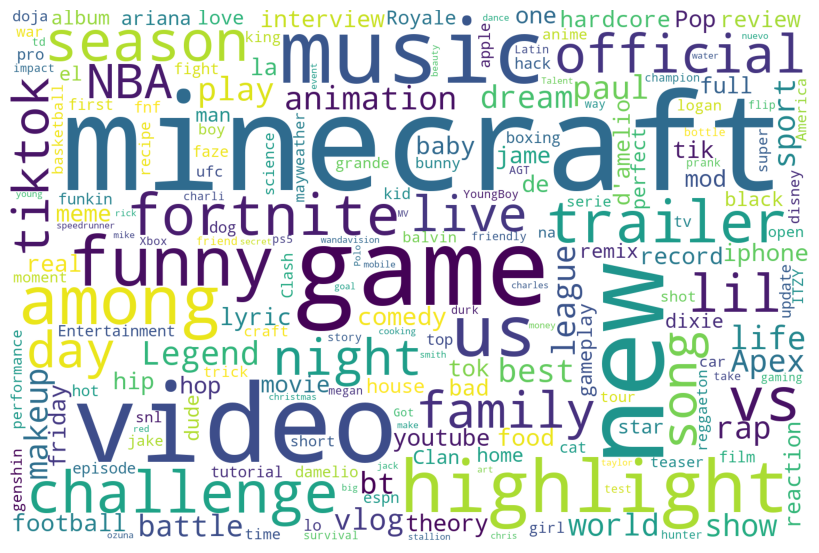

time: 12.5 s (started: 2021-12-10 19:03:24 +00:00)


In [60]:
#WordCloud

VDF502 = usadf.filter(col("tags").isNotNull() & col("view_count").isNotNull()).filter(col("tags") != "[None]").select(split(usadf.tags, '[| ]').alias("tags_list"), col("video_id"),col("title"), col("view_count")).filter(col("view_count") > 1000000)
#VDF502.show()
VDFWORDOUT = [data[0] for data in VDF502.select('tags_list').collect()]
VDF503 = VDF502.select("video_id", "title", explode(VDF502.tags_list).alias("tags")).filter(col("tags") != "[None]")
VDF504 = VDF503.groupby("tags").agg(count("tags")).withColumnRenamed("tags", "TOP 50 Tags Words with More than 1M Views").withColumnRenamed("count(tags)", "Number of Apperances").sort(col("Number of Apperances").desc())
VDF505 = VDF504.select("TOP 50 Tags Words with More than 1M Views", "Number of Apperances").limit(50)
#VDF505.show(100)
#print(VDFWORDOUT)
tags_words = ''
for val in VDFWORDOUT:
  tags_words += " ".join(val)+" " 

#print(tags_words)
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 1500, height = 1000,
                background_color ='white',
                stopwords = stopwords,collocations = False,
                min_font_size = 10).generate(tags_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

##### Video Recommendation

In [61]:
#Check Duplicate Video ID

print("Total Number of ROWS", usadf.count())

#print("Duplicate Video ID List")

#df1=VDF.groupBy("video_id").count().filter("count > 1")
#df1.drop('count').sort("video_id").show(400)


#print("Duplicate Video ID Count")

#df1=VDF.groupBy("video_id").count().filter("count > 1")
#df1.sort("video_id").show(400)


print("Total Number of ROWS After removing duplicates", usadf.dropDuplicates(["video_id"]).dropDuplicates(["title"]).count())

print("Category of Videos in DataSet")

ytvusjdf.show(100)

#Drop Duplicate Video ID and Titles

VDFdropDupDF = usadf.dropDuplicates(["video_id"]).dropDuplicates(["title"])

#Get Tags ordered

df1000 = VDFdropDupDF.join(ytvusjdf, VDFdropDupDF.categoryId == ytvusjdf.id, "left").select("video_id", upper(col('category')), upper(col('tags')), "title", "likes", "dislikes").withColumnRenamed("upper(tags)", "tags").withColumnRenamed("upper(category)", "category").na.replace('[NONE]', None)
df1001_0 = df1000.select("video_id", "title", "likes", "dislikes", regexp_replace(col("category"), " ", ""), regexp_replace(col("tags"), " ", "")).withColumnRenamed("regexp_replace(category,  , )", "category").withColumnRenamed("regexp_replace(tags,  , )", "tags")
df1001 = df1001_0.select("video_id", "category", "title", "likes", "dislikes", split(df1001_0.tags, '[|]', limit=4).alias("tags_list"))
df1002 = df1001.select("video_id", "category", "title", "tags_list", "likes", "dislikes", split(df1001.category, '[|]').alias("category_list"))
df1003 = df1002.select("video_id","category_list","title","tags_list", "likes", "dislikes", concat(df1002.category_list,df1002.tags_list).alias("combined"))
df1004 = df1003.withColumn("combined",coalesce(df1003.combined,df1003.category_list)) 
df1005 = df1004.withColumn("Len", size("combined")).withColumn("Percentage Likes", col("likes")/col("dislikes"))
#df1005.show(truncate=False)
#df1003.show(truncate=False)


#Getting Only Videos Which are related

#df2000 = df1005.select("title", "combined").withColumn("combined_small", array([col("combined")[0], col("combined")[1], col("combined")[2], col("combined")[3]])).limit(10)
df2000 = df1005.select("title", array([col("combined")[0], col("combined")[1], col("combined")[2], col("combined")[3]]).alias("combined_small")).limit(1000)
df2001 = df2000.withColumn("ID", monotonically_increasing_id())
#df2001.show(20,truncate= False)

from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="combined_small", outputCol="tf")
#hashingTF = HashingTF(inputCol="combined", outputCol="tf")
tf = hashingTF.transform(df2001)

idf = IDF(inputCol="tf", outputCol="feature").fit(tf)
tfidf = idf.transform(tf)

#Compute L2 Norm

from pyspark.ml.feature import Normalizer
normalizer = Normalizer(inputCol="feature", outputCol="norm")
data = normalizer.transform(tfidf)

import pyspark.sql.functions as psf
from pyspark.sql.types import DoubleType
dot_udf = psf.udf(lambda x,y: float(x.dot(y)), DoubleType())
final = data.alias("i").join(data.alias("j"), psf.col("i.ID") < psf.col("j.ID"))\
    .select(psf.col("i.ID").alias("i"), psf.col("j.ID").alias("j"), dot_udf("i.norm", "j.norm").alias("dot"))\
    .where(col('dot') != 0).sort("i", "j")
#final.show()


final_video = final.select("j", "i", "dot")
final_video2 = final.union(final_video)
final_video3 = final_video2.sort("i", "dot", ascending=False)
#final3.show()


pandasDF = df2001.toPandas()
sparkDF=spark.createDataFrame(pandasDF)


final_video4 = final_video3.join(sparkDF, sparkDF.ID == final_video3.i).withColumnRenamed("title", "Search Title").drop("ID","combined_small")
final_video5 = final_video4.join(sparkDF, sparkDF.ID == final_video4.j).withColumnRenamed("title", "Recommendation Title").drop("ID")
#final_video4.show(100, truncate=False)
#final_video5.show(100)

pandasDFRecommendation = final_video5.toPandas()
#pandasDFRecommendation



Total Number of ROWS 91791
Total Number of ROWS After removing duplicates 16009
Category of Videos in DataSet
+---+--------------------+
| id|            Category|
+---+--------------------+
|  1|    Film & Animation|
|  2|    Autos & Vehicles|
| 10|               Music|
| 15|      Pets & Animals|
| 17|              Sports|
| 18|        Short Movies|
| 19|     Travel & Events|
| 20|              Gaming|
| 21|       Videoblogging|
| 22|      People & Blogs|
| 23|              Comedy|
| 24|       Entertainment|
| 25|     News & Politics|
| 26|       Howto & Style|
| 27|           Education|
| 28|Science & Technology|
| 29|Nonprofits & Acti...|
| 30|              Movies|
| 31|     Anime/Animation|
| 32|    Action/Adventure|
| 33|            Classics|
| 34|              Comedy|
| 35|         Documentary|
| 36|               Drama|
| 37|              Family|
| 38|             Foreign|
| 39|              Horror|
| 40|      Sci-Fi/Fantasy|
| 41|            Thriller|
| 42|              Shorts|

In [62]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)
pandasDF.to_csv("/content/drive/MyDrive/video_list.csv")
print("List of Videos Taken For Search Operation\n\n")
pandasDF.rename(columns = {'combined_small':'Category_Tags'})[['title', 'Category_Tags']]

List of Videos Taken For Search Operation




,title,Category_Tags
0,*NEW* FERRARI in FORTNITE!,"[GAMING, FORTNITE, FORTNITEBR, FORTNITEBATTLEROYALE]"
1,10 Things Not To Do in SQUID GAME,"[ENTERTAINMENT, GUAVAJUICE, GUAVAJUICEYOUTUBE, YOUTUBEGUAVAJUICE]"
2,41 And PREGNANT,"[PEOPLE&BLOGS, None, None, None]"
3,7 fairly uninteresting projects I've built,"[SCIENCE&TECHNOLOGY, None, None, None]"
4,A VERY EXTRA WISH HAUL.. maybe the most extra ever ?!,"[HOWTO&STYLE, MIAMAPLES, WISHHAUL, VERYEXTRAWISHCLOTHINGHAUL]"
5,Agent Orange (The Vietnam War),"[EDUCATION, SIMPLEHISTORY, ANIMATEDHISTORY, EDUCATIONAL]"
6,Alemán - Mi Tio Snoop Ft Snoop Dogg (Video Oficial),"[MUSIC, ALEMÁN, ALEMANHOMEGROWN, HOMEGROWNMAFIA]"
7,Andrea Bocelli launches EURO 2020!,"[SPORTS, THE_LATEST, UEFA, EURO]"
8,Argentina 3-0 Uruguay I Eliminatorias a Catar 2022,"[SPORTS, TYC, SPORTS, TYCSPORTS]"
9,BTS React To Their First Hot 100 No. 1 Hit ‘Dynamite’ and Tease What's Next | Billboard News,"[MUSIC, BILLBOARD, BILLBOARDCHANNEL, OFFICIAL]"


time: 608 ms (started: 2021-12-10 19:10:04 +00:00)


In [63]:
import pandas as pd
def getRecommendation(video):
  print("\n\n\n")
  print("Search For Recommendation for Video", video, "\n\n\n")
  #displaylist = pandasDFRecommendation.loc[pandasDFRecommendation['Search Title'] == video].sort_values(by = 'dot', ascending=False)['Recommendation Title', 'combined_small'].head(10).tolist()
  #for i in displaylist:
  #  print(i)
  #print(displaydf)
  return pandasDFRecommendation.loc[pandasDFRecommendation['Search Title'] == video].sort_values(by = 'dot', ascending=True).head(10)

dfrecommend = getRecommendation("Internet Money – JETSKI ft. Lil Mosey & Lil Tecca (Official Video)")
dfrecommend.reset_index(drop=True, inplace=True)
dfrecommend.rename(columns = {'combined_small':'Category_Tags'}, inplace = True)
dfrecommend.index = dfrecommend.index + 1
dfrecommend[["Recommendation Title", "Category_Tags"]]





Search For Recommendation for Video Internet Money – JETSKI ft. Lil Mosey & Lil Tecca (Official Video) 





,Recommendation Title,Category_Tags
1,Burna Boy - Monsters You Made [Official Music Video],"[MUSIC, BURNABOY, BURNERBOY, BURNABOY]"
2,Big Scarr Covers Gucci Mane's Hit Song Big Boy Diamonds I 17 Bars,"[MUSIC, AUDIOMACK, AUDIOMACK, TRAPSYMPHONY]"
3,BlocBoy JB - FatBoy (Intro) [Official Music Video],"[MUSIC, BLOCBOY, BLOCBOYJB, BLOCBOY]"
4,SM6 - Oddity (Official Music Video),"[MUSIC, SM6BAND, SM6BAND, SM6]"
5,SpotemGottem - Sosa Flow (Official Video),"[MUSIC, SPOTEMGOTTEM, SPOTEMGOTEM, SPOTEMGOTTEM]"
6,YUNGBLUD with Denzel Curry - Lemonade,"[MUSIC, YUNGBLUD, YUNGBLUD, YOUNGBLOOD]"
7,42 Dugg - Maybach feat. Future (Official Music Video),"[MUSIC, 42DUGG, 42DUGG, DUGG]"
8,"Jennifer Lopez - This Land Is Your Land & America, The Beautiful - Inauguration 2021 Performance","[MUSIC, JENNIFERLOPEZ, JLO, JLO]"
9,Demi Lovato - Commander In Chief (Live from the Billboard Music Awards / 2020),"[MUSIC, DEMILOVATO, BBMAS, BILLBOARDMUSICAWARDS]"
10,Bryant Myers - Se Fuerte,"[MUSIC, BRYANT, MYERS, FUERTE]"


time: 123 ms (started: 2021-12-10 19:10:05 +00:00)
